while inferential statistics and visualizations are important, feature selection and engineering seems like by far the main component of this part of the project, I want to use most of this data but pare it down into fewer but more intelligent features

in order of importance, I'd rank the three tasks as follows:
1) feature selection and engineering<br>
2) visualization and relationships<br>
3) inferential statistics

* [Current Location](#current-loc)

**WARNING**: I should save my pandas profile reports as files and put them on my github with my final notebook so that people viewing my notebook will have access to them, even though they won't display directly in the notebook.  But for purposes of my experimentation, I will just make the reports inline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling

**in my final notebook** I'll probably just import all of my data here at the beginning to stay organized

In [206]:
pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

explore each of my datasets and get familiar with them and their distributions, and how they relate to the target variable (pokemon_df, pokemon_types_df, pokemon_abilities_df, abilities_df, moves_df, pokemon_learnsets_df, strategies_dict), can use pandas profiling reports (does all the basic tasks of histogram visualization, outstanding values, summary statistics, correlations and abnormalities), but also I can do extra visualizations if that would be helpful

In [4]:
pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")

In [5]:
pokemon_df.head()

,hp,atk,def,spa,spd,spe,weight,height,formats,generation
name,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,6.9,0.7,LC,RB
Ivysaur,60,62,63,80,80,60,13.0,1.0,NFE,RB
Venusaur,80,82,83,100,100,80,100.0,2.0,RUBL,RB
Charmander,39,52,43,60,50,65,8.5,0.6,LC,RB
Charmeleon,58,64,58,80,65,80,19.0,1.1,NFE,RB


In [6]:
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738 entries, Bulbasaur to Calyrex-Shadow
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hp          738 non-null    int64  
 1   atk         738 non-null    int64  
 2   def         738 non-null    int64  
 3   spa         738 non-null    int64  
 4   spd         738 non-null    int64  
 5   spe         738 non-null    int64  
 6   weight      738 non-null    float64
 7   height      738 non-null    float64
 8   formats     738 non-null    object 
 9   generation  738 non-null    object 
dtypes: float64(2), int64(6), object(2)
memory usage: 63.4+ KB


In [7]:
profile_report = pokemon_df.profile_report(html={'style': {'full_width': True}})
profile_report.to_widgets()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

The data looks to be in excellent shape in general, with essentially zero problems in the overview.

- The name column is just our key and of course has nothing of any interest.

- The summary stats for HP and other numerical stats probably aren't very important, but it would be interesting to look at their extreme values to see if they point to anything (so maybe we will examine higher and lower percentiles of them layer according to types, abilities, moves, and strategic roles.

- HP histogram looks closer to normal, Attack histogram has a lot more cutoff points where it gets very high and then low again (HP does this too, just not as much)

- Def and Spd (defense and special defense) look more similar to HP and are a bit smoother, whereas speed and ESPECIALLY special attack (spa) look similar to attack.  So it does seem like more offensive stats (Attack, Special Attack and Speed) have more similarity with one another, just as more defensive stats do (HP, Defense, Special Defense)

- Weight and Height, which aren't combat stats (but can occasionally be relevant for some moves and abilities) are quite different have long right-tails, whereas other stats are closer to normally distributed (but far from exactly obviously)

- Our formats are heavily skewed, since the three largest bins are LC, Untiered and NFE, all of which are being aggregated into the lowest competitive tier, ZU (ZeroUsed).  It's over half of the in that one of seven categories.  If my model doesn't have enough examples in the other categories to be successful, I can change my problem to a binary predictions of whether a pokemon in competitive or not (whether it is in one of the three top categories in this formats profile report or not)

- There is nothing of interest in the generations table, it would just be interesting if it contained any patterns for later in our analysis and it won't be used in our machine learning model since it has nothing to do with the competitive stats of a pokemon

- There really aren't any overwhelmingly strong correlations in this data.  Weight and height is the only correlation that is mildly noteworthy and those are by far the least significant stats that rarely come into play anyways.

- It would be interesting to examine the correlation to other variables in my other datasets, so we should check that out later.

In [8]:
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")

In [9]:
pokemon_types_df.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
name,,,,,,,,,,,,,,,,,,
Bulbasaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Ivysaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Venusaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Charmander,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
pokemon_types_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738 entries, Bulbasaur to Calyrex-Shadow
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Bug       738 non-null    int64
 1   Dark      738 non-null    int64
 2   Dragon    738 non-null    int64
 3   Electric  738 non-null    int64
 4   Fairy     738 non-null    int64
 5   Fighting  738 non-null    int64
 6   Fire      738 non-null    int64
 7   Flying    738 non-null    int64
 8   Ghost     738 non-null    int64
 9   Grass     738 non-null    int64
 10  Ground    738 non-null    int64
 11  Ice       738 non-null    int64
 12  Normal    738 non-null    int64
 13  Poison    738 non-null    int64
 14  Psychic   738 non-null    int64
 15  Rock      738 non-null    int64
 16  Steel     738 non-null    int64
 17  Water     738 non-null    int64
dtypes: int64(18)
memory usage: 109.5+ KB


Since the correlations probably aren't very high here, I'm going to lower the threshold for high correlations so it warns me more often, down to 0.5

In [20]:
profile_report = pokemon_types_df.profile_report(html={'style': {'full_width': True}}, correlations={"pearson":{"threshold":0.5}})
profile_report.to_widgets()

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

There are no significant correlations in types, even set as low as 0.5.

Since this is a really simple dataset, it may be interesting to just to some value_counts to see which types are the most common.

In [14]:
pokemon_types_df.sum().sort_values()

Bug          50
Fire         51
Ice          51
Dark         52
Electric     52
Fairy        52
Fighting     52
Poison       55
Rock         57
Steel        58
Ghost        59
Dragon       62
Ground       64
Normal       66
Flying       74
Grass        77
Psychic      90
Water       112
dtype: int64

This is interesting: water types are by far the most common.  Most types are bunched by closely between 50-66 occurences, no more than 3 apart, but the most common are: Water, Psychic, Grass, and Flying.

Understanding how common types are could be significant in understanding correlations between types and other values, since I might have to divide by how many there are in the type to understand the real percentage differences between types.

In [15]:
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")

In [16]:
pokemon_abilities_df.head()

,Cute Charm,Effect Spore,Flame Body,Flash Fire,Intimidate,Lightning Rod,Minus,Plus,Poison Point,Pressure,...,Quick Draw,Ripen,Sand Spit,Screen Cleaner,Stalwart,Steam Engine,Steely Spirit,Transistor,Unseen Fist,Wandering Spirit
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmander,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
pokemon_abilities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738 entries, Bulbasaur to Calyrex-Shadow
Columns: 242 entries, Cute Charm to Wandering Spirit
dtypes: int64(242)
memory usage: 1.4+ MB


In [25]:
profile_report = pokemon_abilities_df.profile_report(html={'style': {'full_width': True}}, correlations={"pearson":{"threshold":0.9}})
profile_report.to_widgets()

Summarize dataset:   0%|          | 0/257 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

High Correlations (for potential binning):
- Triage/Flower Veil

These do only belong to one Pokemon, Comfey, so they can be bucketed, but it isn't very significant considering their rarity and the fact that Comfey mainly uses its 3rd ability which is neither one of those.  It's probably more important for us to remove non-competitive abilities and moves first (of which there are many) before we waste time considering such abilities and moves in our bucketing task.

We will also want to do value counts for our abilities and maybe make a pandas series out of the sum so we can do summary statistics, and sort them like we did with types, and perhaps get extreme values with head and tail.

In [21]:
pokemon_abilities_sums = pokemon_abilities_df.sum()
pokemon_abilities_sums

Cute Charm          12
Effect Spore         7
Flame Body          18
Flash Fire          17
Intimidate          22
                    ..
Steam Engine         3
Steely Spirit        1
Transistor           1
Unseen Fist          2
Wandering Spirit     2
Length: 242, dtype: int64

In [22]:
pokemon_abilities_sums.describe()

count    242.000000
mean       7.132231
std        6.875227
min        1.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       34.000000
dtype: float64

In [23]:
pokemon_abilities_sums.sort_values()

Schooling        1
Fairy Aura       1
Triage           1
Flower Gift      1
Surge Surfer     1
                ..
Pressure        26
Sturdy          28
Levitate        30
Inner Focus     32
Swift Swim      34
Length: 242, dtype: int64

These most common abilities are interesting:
- Swift Swim is a common ability for water types, so it makes sense that it would occur a lot because water types are by far the most common type
- Pressure is common in legendary pokemon, of which there are many.
- I can't think of any reason for Inner Focus, Levitate and Sturdy being common, but they are pretty useful abilities competitively, especially Levitate and Sturdy

The least common abilities are less interesting because there are many abilities which are unique to one pokemon, so it doesn't give much information.

**!!!!! ACTUAL START !!!!!** (the above can be skipped for purposes of continuing the notebook)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling

pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

While the above is interesting, I am unlikely to make much more progress by making profile reports to analyze my different sections of data separately from one another.  The main task I need to do now to make my data more tractable to work with (for EDA and machine learning) is to bucket my moves and abilities, applying a lot of dimensionality reduction to them.  The main tools I'm going to use for this:
- expert knowledge from strategies_dict, which will tell us which moves and abilities are used competitively.  Moves and abilities without competitive use can simply be removed and hopefully that will be a lot of them, which will make our task a lot easier and remove extraneous things that we'd have to change later.  I will have to add abilities to strategies_dict though, which will require some data wrangling (but it's not difficult since it will basically be the same as adding the moves)
- PCA (probably not useful due to what this article explains: https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6, e.g. most of our data is one-hot encoded so applying PCA to rotate coordinate systems doesn't make sense, and the moves with most variance don't necessarily explain which pokemon are most competitive)
- feature stepwise selection (generally seems inferior to the below for reasons listed in the links, even though it's computationally efficient)
- gradient boosting/decision trees/random forest feature importance
- lasso and ridge regression (https://stats.stackexchange.com/questions/367155/why-lasso-for-feature-selection), (https://stats.stackexchange.com/questions/218208/what-are-the-advantages-of-stepwise-regression/218223#218223), (https://stats.stackexchange.com/questions/93181/ridge-lasso-and-elastic-net)

I will have to add abilities to strategies_dict though, which will require some data wrangling (but it's not difficult since it will basically be the same as adding the moves).  I'll just remake it with abilities in the proper part of the dictionary, which we'll have to start doing by remaking strategydex_df because this contained all the strategy information scraped from Smogon about how to use the pokemon:

In [2]:
with open("smogonpokemondata2021/smogonpokemondata2021/scraped_data/PokemonData2021.csv", encoding="utf8") as infile:
    strategydex_df = pd.read_csv(infile)

strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<p>.+?<\/p>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<section>.+?<\/section>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<h1>.+?<\/h1>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\\\\n', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace("\'", '\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('King\"s', "King\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Maki\"s', "Maki\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Land\"s', "Land\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Dragon\"s', "Dragon\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Sirfetch\"d', "Sirfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Farfetch\"d', "Farfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Nature\"s', "Nature\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Forest\"s', "Forest\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('drampa\"s', "drampa\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('False', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('True', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('None', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\"\"\"\s', '\"', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<ul>.+?<\/ul', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Swipe', 'False Swipe') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Surrender', 'False Surrender') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].apply(json.loads)

In [3]:
acceptable_formats = pokemon_df['formats'].unique().tolist()
acceptable_formats.append('ZU')

strategies_dict = {}
strategydexcopy = strategydex_df.copy()

for pokemon in pokemon_df.index:
    pokemon_access = pokemon.replace("'", "").replace(" ", "-").replace(".", "").replace("-10%", "").replace(":", "")
    dex_entry = strategydexcopy.loc[strategydexcopy['pokemonName'] == pokemon_access.lower(), 'pokemonData'].item()
    format_list = []
    for competitive_format in dex_entry['strategies']:
        format_dict = {}
        current_format = competitive_format['format']
        if current_format in acceptable_formats:
            moveset_list = []
            for moveset in competitive_format['movesets']:
                moveset_dict = {}
                moveset_name = moveset['name']
                move_list = []
                for move in moveset['moveslots']:
                    for entry in move:
                        move_list.append(entry['move'])
                moveset_dict[moveset_name] = move_list
                moveset_dict["abilities"] = moveset['abilities']
                moveset_list.append(moveset_dict)
            format_dict[current_format] = moveset_list
            format_list.append(format_dict)
    strategies_dict[pokemon] = format_list

So now we have a strategies_dict which has all of the abilities used by each of the competitive movesets each pokemon has.  What I can do with this is make a list (or a set, more likely) of which abilities are used competitively, which in turn will tell me which abilities have no competitive use (and thus can be removed).

In [61]:
abilities_set = set()
for formatlist in strategies_dict.values():
    for formatdict in formatlist:
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                for ability in moveset['abilities']:
                    abilities_set.add(ability)
abilities_set

{'Adaptability',
 'Aftermath',
 'Air Lock',
 'Analytic',
 'Arena Trap',
 'Aroma Veil',
 'As One (Glastrier)',
 'As One (Spectrier)',
 'Battery',
 'Battle Armor',
 'Beast Boost',
 'Berserk',
 'Blaze',
 'Bulletproof',
 'Chilling Neigh',
 'Chlorophyll',
 'Clear Body',
 'Cloud Nine',
 'Competitive',
 'Compound Eyes',
 'Contrary',
 'Corrosion',
 'Cursed Body',
 'Cute Charm',
 'Damp',
 'Dark Aura',
 'Dauntless Shield',
 'Defeatist',
 'Defiant',
 'Disguise',
 'Download',
 "Dragon's Maw",
 'Drizzle',
 'Drought',
 'Dry Skin',
 'Effect Spore',
 'Electric Surge',
 'Emergency Exit',
 'Fairy Aura',
 'Flame Body',
 'Flash Fire',
 'Fluffy',
 'Frisk',
 'Full Metal Body',
 'Fur Coat',
 'Gale Wings',
 'Gluttony',
 'Gorilla Tactics',
 'Grassy Surge',
 'Grim Neigh',
 'Gulp Missile',
 'Guts',
 'Healer',
 'Heatproof',
 'Heavy Metal',
 'Huge Power',
 'Hunger Switch',
 'Hustle',
 'Hydration',
 'Ice Face',
 'Ice Scales',
 'Illusion',
 'Imposter',
 'Infiltrator',
 'Inner Focus',
 'Insomnia',
 'Intimidate',
 'Ir

In [62]:
len(abilities_set)

175

In [158]:
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
abilities_df

,description
name,
Cute Charm,30% chance of infatuating Pokemon of the oppos...
Effect Spore,30% chance of poison/paralysis/sleep on others...
Flame Body,30% chance a Pokemon making contact with this ...
Flash Fire,This Pokemon's Fire attacks do 1.5x damage if ...
Intimidate,"On switch-in, this Pokemon lowers the Attack o..."
...,...
Steam Engine,This Pokemon's Speed is raised by 6 stages aft...
Steely Spirit,This Pokemon and its allies' Steel-type moves ...
Transistor,This Pokemon's attacking stat is multiplied by...


So only 175 out of the 242 abilities in abilities_df are used competitively.  We'll remove the abilities we no longer need, but first let's see how many moves are left by removing non-competitive moves so I can finish this "step" and see how much work is ahead of me.

In [73]:
moves_set = set()
for formatlist in strategies_dict.values():
    for formatdict in formatlist:
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                keylist = list(moveset.keys())
                keylist.remove('abilities')
                for ability in moveset[keylist[0]]:
                    moves_set.add(ability)
moves_set

{'Accelerock',
 'Acid Armor',
 'Acrobatics',
 'Aerial Ace',
 'Agility',
 'Air Slash',
 'Amnesia',
 'Ancient Power',
 'Apple Acid',
 'Aqua Jet',
 'Aromatherapy',
 'Assurance',
 'Astral Barrage',
 'Attract',
 'Aura Sphere',
 'Aura Wheel',
 'Aurora Veil',
 'Autotomize',
 'Avalanche',
 'Beat Up',
 'Behemoth Bash',
 'Belly Drum',
 'Blaze Kick',
 'Blizzard',
 'Block',
 'Blue Flare',
 'Body Press',
 'Body Slam',
 'Bolt Beak',
 'Bolt Strike',
 'Bonemerang',
 'Boomburst',
 'Bounce',
 'Brave Bird',
 'Brick Break',
 'Brutal Swing',
 'Bug Bite',
 'Bug Buzz',
 'Bulk Up',
 'Bullet Punch',
 'Bullet Seed',
 'Burning Jealousy',
 'Calm Mind',
 'Circle Throw',
 'Clanging Scales',
 'Clangorous Soul',
 'Clear Smog',
 'Close Combat',
 'Coil',
 'Confide',
 'Copycat',
 'Corrosive Gas',
 'Cosmic Power',
 'Cotton Guard',
 'Counter',
 'Covet',
 'Crabhammer',
 'Crunch',
 'Crush Claw',
 'Curse',
 'Dark Pulse',
 'Darkest Lariat',
 'Dazzling Gleam',
 'Defog',
 'Destiny Bond',
 'Diamond Storm',
 'Disable',
 'Discharg

In [74]:
len(moves_set)

350

In [159]:
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
moves_df

,category,power,accuracy,priority,pp,description,type
name,,,,,,,
Acid,Special,40,100,0,30,10% chance to lower the foe(s) Sp. Def by 1.,Poison
Amnesia,Non-Damaging,0,0,0,20,Raises the user's Sp. Def by 2.,Psychic
Aurora Beam,Special,65,100,0,20,10% chance to lower the target's Attack by 1.,Ice
Bind,Physical,15,85,0,20,Traps and damages the target for 4-5 turns.,Normal
Bite,Physical,60,100,0,25,30% chance to make the target flinch.,Dark
...,...,...,...,...,...,...,...
Terrain Pulse,Special,50,100,0,10,"User on terrain: power doubles, type varies.",Normal
Thunder Cage,Special,80,90,0,15,Traps and damages the target for 4-5 turns.,Electric
Thunderous Kick,Physical,90,100,0,10,100% chance to lower the target's Defense by 1.,Fighting


We did get rid of almost half of the moves, which is good!  Let's actually make these removals.

In [171]:
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')

In [172]:
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
abilities_removed_df

0         Color Change
1             Forecast
2          Magma Armor
3           Pure Power
4           Bad Dreams
5            Normalize
6            Multitype
7          Poison Heal
8          Toxic Boost
9             Aerilate
10       Parental Bond
11        Delta Stream
12       Desolate Land
13          Grass Pelt
14      Primordial Sea
15             Protean
16         Battle Bond
17            Comatose
18              Dancer
19            Dazzling
20           Galvanize
21          Neuroforce
22    Power of Alchemy
23        Shields Down
24      Intrepid Sword
Name: name, dtype: object

In [173]:
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

In [174]:
pokemon_learnsets_df

,Acid,Amnesia,Aurora Beam,Bind,Bite,Blizzard,Bubble Beam,Conversion,Counter,Crabhammer,...,Strange Steam,Stuff Cheeks,Surging Strikes,Tar Shot,Teatime,Terrain Pulse,Thunder Cage,Thunderous Kick,Triple Axel,Wicked Blow
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Charmander,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
def inset(value, refset):
    if value in refset:
        return True
    else:
        return False

For abilities, I need to change abilities_removed_df, abilities_df, and pokemon_abilities_df

In [207]:
abilities_to_remove = abilities_df.loc[~abilities_df.index.to_series().apply(lambda x: inset(x, abilities_set))]
abilities_to_remove

,description
name,
Minus,If an active ally has this Ability or the Plus...
Plus,If an active ally has this Ability or the Minu...
Rain Dish,"If Rain Dance is active, this Pokemon heals 1/..."
Truant,This Pokemon skips every other turn instead of...
Pickup,"If this Pokemon has no item, it finds one used..."
...,...
Quick Draw,This Pokemon has a 30% chance to move first in...
Ripen,"When this Pokemon eats a Berry, its effect is ..."
Sand Spit,"When this Pokemon is hit, Sandstorm begins."


In [208]:
moves_to_remove = moves_df.loc[~moves_df.index.to_series().apply(lambda x: inset(x, moves_set))]
moves_to_remove

,category,power,accuracy,priority,pp,description,type
name,,,,,,,
Acid,Special,40,100,0,30,10% chance to lower the foe(s) Sp. Def by 1.,Poison
Aurora Beam,Special,65,100,0,20,10% chance to lower the target's Attack by 1.,Ice
Bind,Physical,15,85,0,20,Traps and damages the target for 4-5 turns.,Normal
Bite,Physical,60,100,0,25,30% chance to make the target flinch.,Dark
Bubble Beam,Special,65,100,0,20,10% chance to lower the target's Speed by 1.,Water
...,...,...,...,...,...,...,...
Stuff Cheeks,Non-Damaging,0,0,0,10,"Must hold Berry to use. User eats Berry, Def +2.",Normal
Tar Shot,Non-Damaging,0,100,0,15,Target gets -1 Spe and becomes weaker to Fire.,Rock
Teatime,Non-Damaging,0,0,0,10,All active Pokemon consume held Berries.,Normal


In [209]:
abilities_removed_df = abilities_removed_df.append(pd.Series(abilities_to_remove.index.values), ignore_index=True)
abilities_removed_df

0     Color Change
1         Forecast
2      Magma Armor
3       Pure Power
4       Bad Dreams
          ...     
87      Quick Draw
88           Ripen
89       Sand Spit
90        Stalwart
91    Steam Engine
Length: 92, dtype: object

In [210]:
abilities_df = abilities_df.loc[abilities_df.index.to_series().apply(lambda x: inset(x, abilities_set))]
abilities_df

,description
name,
Cute Charm,30% chance of infatuating Pokemon of the oppos...
Effect Spore,30% chance of poison/paralysis/sleep on others...
Flame Body,30% chance a Pokemon making contact with this ...
Flash Fire,This Pokemon's Fire attacks do 1.5x damage if ...
Intimidate,"On switch-in, this Pokemon lowers the Attack o..."
...,...
Screen Cleaner,"On switch-in, the effects of Aurora Veil, Ligh..."
Steely Spirit,This Pokemon and its allies' Steel-type moves ...
Transistor,This Pokemon's attacking stat is multiplied by...


In [211]:
pokemon_abilities_df = pokemon_abilities_df.drop(columns=abilities_to_remove.index.to_list())
pokemon_abilities_df

,Cute Charm,Effect Spore,Flame Body,Flash Fire,Intimidate,Lightning Rod,Poison Point,Pressure,Rough Skin,Shadow Tag,...,Mimicry,Neutralizing Gas,Pastel Veil,Power Spot,Punk Rock,Screen Cleaner,Steely Spirit,Transistor,Unseen Fist,Wandering Spirit
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmander,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For moves, I need to change moves_df and pokemon_learnsets_df

In [212]:
moves_df = moves_df.loc[moves_df.index.to_series().apply(lambda x: inset(x, moves_set))]
moves_df

,category,power,accuracy,priority,pp,description,type
name,,,,,,,
Amnesia,Non-Damaging,0,0,0,20,Raises the user's Sp. Def by 2.,Psychic
Blizzard,Special,110,70,0,5,10% chance to freeze foe(s). Can't miss in hail.,Ice
Counter,Physical,0,100,-5,20,"If hit by physical attack, returns double damage.",Fighting
Crabhammer,Physical,100,90,0,10,High critical hit ratio.,Water
Disable,Non-Damaging,0,100,0,20,"For 4 turns, disables the target's last move u...",Normal
...,...,...,...,...,...,...,...
Strange Steam,Special,90,95,0,10,20% chance to confuse the target.,Fairy
Surging Strikes,Physical,25,100,0,5,Always results in a critical hit. Hits 3 times.,Water
Thunderous Kick,Physical,90,100,0,10,100% chance to lower the target's Defense by 1.,Fighting


In order to remove moves from learnsets, we'll have to get rid of the list of moves we already removed last time in our moves_to_remove list: ['Struggle' 'Behemoth Blade' 'G-Max Befuddle' 'G-Max Cannonade'\n 'G-Max Centiferno' 'G-Max Chi Strike' 'G-Max Cuddle' 'G-Max Depletion'\n 'G-Max Drum Solo' 'G-Max Finale' 'G-Max Fire Ball' 'G-Max Foam Burst'\n 'G-Max Gold Rush' 'G-Max Gravitas' 'G-Max Hydrosnipe' 'G-Max Malodor'\n 'G-Max Meltdown' 'G-Max One Blow' 'G-Max Rapid Flow' 'G-Max Replenish'\n 'G-Max Resonance' 'G-Max Sandblast' 'G-Max Smite' 'G-Max Snooze'\n 'G-Max Steelsurge' 'G-Max Stonesurge' 'G-Max Stun Shock'\n 'G-Max Sweetness' 'G-Max Tartness' 'G-Max Terror' 'G-Max Vine Lash'\n 'G-Max Volcalith' 'G-Max Volt Crash' 'G-Max Wildfire' 'G-Max Wind Rage'\n 'Max Airstream' 'Max Darkness' 'Max Flare' 'Max Flutterby' 'Max Geyser'\n 'Max Guard' 'Max Hailstorm' 'Max Knuckle' 'Max Lightning' 'Max Mindstorm'\n 'Max Ooze' 'Max Overgrowth' 'Max Phantasm' 'Max Quake' 'Max Rockfall'\n 'Max Starfall' 'Max Steelspike' 'Max Strike' 'Max Wyrmwind']

In [213]:
already_removed = "['Struggle' 'Behemoth Blade' 'G-Max Befuddle' 'G-Max Cannonade'\n 'G-Max Centiferno' 'G-Max Chi Strike' 'G-Max Cuddle' 'G-Max Depletion'\n 'G-Max Drum Solo' 'G-Max Finale' 'G-Max Fire Ball' 'G-Max Foam Burst'\n 'G-Max Gold Rush' 'G-Max Gravitas' 'G-Max Hydrosnipe' 'G-Max Malodor'\n 'G-Max Meltdown' 'G-Max One Blow' 'G-Max Rapid Flow' 'G-Max Replenish'\n 'G-Max Resonance' 'G-Max Sandblast' 'G-Max Smite' 'G-Max Snooze'\n 'G-Max Steelsurge' 'G-Max Stonesurge' 'G-Max Stun Shock'\n 'G-Max Sweetness' 'G-Max Tartness' 'G-Max Terror' 'G-Max Vine Lash'\n 'G-Max Volcalith' 'G-Max Volt Crash' 'G-Max Wildfire' 'G-Max Wind Rage'\n 'Max Airstream' 'Max Darkness' 'Max Flare' 'Max Flutterby' 'Max Geyser'\n 'Max Guard' 'Max Hailstorm' 'Max Knuckle' 'Max Lightning' 'Max Mindstorm'\n 'Max Ooze' 'Max Overgrowth' 'Max Phantasm' 'Max Quake' 'Max Rockfall'\n 'Max Starfall' 'Max Steelspike' 'Max Strike' 'Max Wyrmwind']"
cleaned_already_removed = already_removed.replace('\n', '').replace("\' \'", ",").replace("\'", "").replace('[', "").replace(']', "")
clean_already_removed = cleaned_already_removed.split(',')
moves_to_remove = [move for move in moves_to_remove.index.values if move not in clean_already_removed]
moves_to_remove

['Acid',
 'Aurora Beam',
 'Bind',
 'Bite',
 'Bubble Beam',
 'Conversion',
 'Dig',
 'Fly',
 'Gust',
 'Metronome',
 'Mimic',
 'Poison Sting',
 'Razor Leaf',
 'Rock Throw',
 'Sand Attack',
 'Skull Bash',
 'Slash',
 'Sludge',
 'Wing Attack',
 'Wrap',
 'Petal Dance',
 'Poison Gas',
 'Poison Powder',
 'Sky Attack',
 'Thrash',
 'Absorb',
 'Mega Drain',
 'Vine Whip',
 'Dream Eater',
 'Minimize',
 'Mist',
 'Tackle',
 'Growl',
 'Lick',
 'Pin Missile',
 'Screech',
 'Sing',
 'Smog',
 'String Shot',
 'Submission',
 'Supersonic',
 'Confuse Ray',
 'Confusion',
 'Cut',
 'Defense Curl',
 'Double Kick',
 'Double Team',
 'Drill Peck',
 'Ember',
 'Fissure',
 'Fury Attack',
 'Fury Swipes',
 'Guillotine',
 'Harden',
 'Headbutt',
 'Horn Attack',
 'Horn Drill',
 'Hyper Beam',
 'Kinesis',
 'Leer',
 'Mega Punch',
 'Pay Day',
 'Peck',
 'Pound',
 'Scratch',
 'Slam',
 'Smokescreen',
 'Splash',
 'Stomp',
 'Swift',
 'Tail Whip',
 'Take Down',
 'Thunder Shock',
 'Vice Grip',
 'Water Gun',
 'Withdraw',
 'Aeroblast',
 

In [216]:
pokemon_learnsets_df = pokemon_learnsets_df.drop(columns=moves_to_remove)
pokemon_learnsets_df

,Amnesia,Blizzard,Counter,Crabhammer,Disable,Double-Edge,Explosion,Fire Blast,Fire Spin,Focus Energy,...,Scale Shot,Scorching Sands,Skitter Smack,Spirit Break,Steel Beam,Strange Steam,Surging Strikes,Thunderous Kick,Triple Axel,Wicked Blow
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmander,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**The step of cleaning my data so that non-competitive abilities and moves are removed is complete!**

Random Forest and Lasso Regression are things I can complete later when my features are cleaned more.  First, I need to make a list of the roles played by pokemon, and understand their distribution in terms of moves and abilities (and eventually other things as well but for now moves and abilities are really what are important.

I can make the roles set using the same method I did for the abilities and moves.

In [4]:
roles_set = set()
for formatlist in strategies_dict.values():
    for formatdict in formatlist:
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                role = [name for name in moveset.keys() if name != 'abilities']
                roles_set.add(role[0])
roles_set

{'3 Attacks + Roost',
 '3 Attacks Roost',
 'Agility',
 'All Out Attacker',
 'All out Attacker',
 'All-Out Attacker',
 'All-Out-Attacker',
 'All-out Attacker',
 'Assault Vest',
 'Aurora Veil',
 'Autotomize',
 'Autotomize Sweeper',
 'Belly Drum',
 'Berry Juice',
 'Berry Juice Pivot',
 'Breaker',
 'Bulk Up',
 'Bulky Attacker',
 'Bulky Booster',
 'Bulky Calm Mind',
 'Bulky Pivot',
 'Bulky Quiver Dance',
 'Bulky Setup Sweeper',
 'Bulky Swords Dance',
 'Bulky Utility',
 'Calm Mind',
 'Chlorophyll Sweeper',
 'Choice',
 'Choice Attacker',
 'Choice Band',
 'Choice Item',
 'Choice Scarf',
 'Choice Scarf Cleaner',
 'Choice Scarf Trapper',
 'Choice Specs',
 'Choiced Attacker',
 'Clangorous Soul',
 'Cleaner',
 'Cleric',
 'Cosmic Power',
 'Cosmic Power + Stored Power',
 'Cotton Guard',
 'CritDra',
 'Crocune',
 'Curse',
 'Curselax',
 'DAT LOUD',
 'Defensive',
 'Defensive Calm Mind',
 'Defensive Calm Mind + Recover',
 'Defensive Dragon Dance',
 'Defensive Pivot',
 'Defensive Spikes',
 'Defensive Spinn

In [5]:
len(roles_set)

242

Now what we need to do is bucket these roles into fewer, more understandable roles (and possibly small variations on them) to create intelligent features.  Then we can make a dictionary with all of the roles, and which pokemon, moves and abilities are associated with them, and then combine these dictionaries according to the intelligent features we want to make so that we can see which pokemon could potentially play them (without regard for stats which is something to be assessed by our model which will likely be random forest).

In [223]:
type({})

dict

<font size="6">**ANOTHER ACTUAL START!!!!!**</font>

- in order to be able to groupby my target feature, I’m going to need to clean up its column (so I should start transforming the banlist columns as well), Mesh together each format (e.g. UUBL to OU) so I know how many I have of each format and so I can do groupby’s!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling

pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

with open("smogonpokemondata2021/smogonpokemondata2021/scraped_data/PokemonData2021.csv", encoding="utf8") as infile:
    strategydex_df = pd.read_csv(infile)

strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<p>.+?<\/p>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<section>.+?<\/section>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<h1>.+?<\/h1>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\\\\n', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace("\'", '\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('King\"s', "King\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Maki\"s', "Maki\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Land\"s', "Land\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Dragon\"s', "Dragon\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Sirfetch\"d', "Sirfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Farfetch\"d', "Farfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Nature\"s', "Nature\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Forest\"s', "Forest\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('drampa\"s', "drampa\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('False', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('True', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('None', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\"\"\"\s', '\"', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<ul>.+?<\/ul', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Swipe', 'False Swipe') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Surrender', 'False Surrender') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].apply(json.loads)

acceptable_formats = pokemon_df['formats'].unique().tolist()
acceptable_formats.append('ZU')

strategies_dict = {}
strategydexcopy = strategydex_df.copy()

for pokemon in pokemon_df.index:
    pokemon_access = pokemon.replace("'", "").replace(" ", "-").replace(".", "").replace("-10%", "").replace(":", "")
    dex_entry = strategydexcopy.loc[strategydexcopy['pokemonName'] == pokemon_access.lower(), 'pokemonData'].item()
    format_list = []
    for competitive_format in dex_entry['strategies']:
        format_dict = {}
        current_format = competitive_format['format']
        if current_format in acceptable_formats:
            moveset_list = []
            for moveset in competitive_format['movesets']:
                moveset_dict = {}
                moveset_name = moveset['name']
                move_list = []
                for move in moveset['moveslots']:
                    for entry in move:
                        move_list.append(entry['move'])
                moveset_dict[moveset_name] = move_list
                moveset_dict["abilities"] = moveset['abilities']
                moveset_list.append(moveset_dict)
            format_dict[current_format] = moveset_list
            format_list.append(format_dict)
    strategies_dict[pokemon] = format_list

In [2]:
pokemon_df

,hp,atk,def,spa,spd,spe,weight,height,formats,generation
name,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,6.9,0.7,LC,RB
Ivysaur,60,62,63,80,80,60,13.0,1.0,NFE,RB
Venusaur,80,82,83,100,100,80,100.0,2.0,RUBL,RB
Charmander,39,52,43,60,50,65,8.5,0.6,LC,RB
Charmeleon,58,64,58,80,65,80,19.0,1.1,NFE,RB
...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,800.0,2.2,NU,SS
Spectrier,100,65,60,145,80,130,44.5,2.0,Uber,SS
Calyrex,100,80,80,80,80,80,7.7,1.1,Untiered,SS


In [3]:
pokemon_df['formats'].unique()

array(['LC', 'NFE', 'RUBL', 'PU', 'NU', 'Untiered', 'UU', 'OU', 'UUBL',
       'PUBL', 'RU', 'Uber', 'NUBL'], dtype=object)

In [4]:
pokemon_df.loc[pokemon_df['formats'] == 'LC', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'NFE', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'Untiered', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'PUBL', 'formats'] = 'NU'
pokemon_df.loc[pokemon_df['formats'] == 'NUBL', 'formats'] = 'RU'
pokemon_df.loc[pokemon_df['formats'] == 'RUBL', 'formats'] = 'UU'
pokemon_df.loc[pokemon_df['formats'] == 'UUBL', 'formats'] = 'OU'

In [5]:
pokemon_df['formats'].unique()

array(['ZU', 'UU', 'PU', 'NU', 'OU', 'RU', 'Uber'], dtype=object)

In [6]:
pokemon_df

,hp,atk,def,spa,spd,spe,weight,height,formats,generation
name,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,6.9,0.7,ZU,RB
Ivysaur,60,62,63,80,80,60,13.0,1.0,ZU,RB
Venusaur,80,82,83,100,100,80,100.0,2.0,UU,RB
Charmander,39,52,43,60,50,65,8.5,0.6,ZU,RB
Charmeleon,58,64,58,80,65,80,19.0,1.1,ZU,RB
...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,800.0,2.2,NU,SS
Spectrier,100,65,60,145,80,130,44.5,2.0,Uber,SS
Calyrex,100,80,80,80,80,80,7.7,1.1,ZU,SS


In [7]:
pokemon_df['formats'].value_counts()

ZU      474
RU       55
OU       49
NU       48
UU       41
Uber     37
PU       34
Name: formats, dtype: int64

In [8]:
pokemon_df.groupby(['formats'])['hp'].mean().sort_values()

formats
ZU       62.392405
NU       77.937500
PU       79.647059
RU       85.309091
UU       88.146341
OU       89.040816
Uber    104.432432
Name: hp, dtype: float64

In [9]:
pokemon_df.groupby(['formats'])['atk'].mean().sort_values()

formats
ZU       67.510549
NU       93.833333
RU       94.490909
PU       95.441176
UU       96.390244
OU       99.795918
Uber    120.081081
Name: atk, dtype: float64

In [10]:
pokemon_df.groupby(['formats'])['def'].mean().sort_values()

formats
ZU      67.428270
NU      85.979167
UU      86.780488
OU      89.775510
PU      90.352941
RU      94.418182
Uber    99.675676
Name: def, dtype: float64

In [11]:
pokemon_df.groupby(['formats'])['spa'].mean().sort_values()

formats
ZU       61.862869
PU       74.764706
RU       87.527273
NU       87.895833
UU       88.170732
OU       92.836735
Uber    117.405405
Name: spa, dtype: float64

In [12]:
pokemon_df.groupby(['formats'])['spd'].mean().sort_values()

formats
ZU       64.582278
PU       81.852941
RU       83.945455
UU       87.658537
OU       87.938776
NU       90.895833
Uber    100.432432
Name: spd, dtype: float64

In [13]:
pokemon_df.groupby(['formats'])['spe'].mean().sort_values()

formats
ZU       58.742616
RU       77.490909
PU       78.676471
NU       79.000000
UU       79.000000
OU       86.938776
Uber    101.621622
Name: spe, dtype: float64

In [14]:
pokemon_df.groupby(['formats'])['weight'].mean().sort_values()

formats
ZU       41.174895
UU       95.865854
PU       99.747059
OU      104.975510
RU      117.089091
NU      126.570833
Uber    308.808108
Name: weight, dtype: float64

In [15]:
pokemon_df.groupby(['formats'])['height'].mean().sort_values()

formats
ZU      0.957173
PU      1.497059
NU      1.541667
OU      1.583673
UU      1.756098
RU      1.778182
Uber    3.762162
Name: height, dtype: float64

- These results are sensible, but there is a slight problem that some of my classes in general don't have many examples (PU, Uber have under 40, which is especially problematic when splitting into training and testing).  And really all except ZU don't have as many as I'd like.

Another very interesting idea, to pad my classes: use strategies_dict to put together in the tier of their highest strategy, rather than their lowest (and I can even try it on both), could optionally have constraints like “you can’t go more than one tier higher than your listed tier”, might try both of these and see how it goes

- So first I'm going to need to have a list of formats ordered by how high the format is, so if the pokemon has a moveset for such a format, then I don't have to check the lower formats.

In [26]:
ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']
tierchange_df

,Tier,Change
name,,
Bulbasaur,ZU,NaN
Ivysaur,ZU,NaN
Venusaur,UU,NaN
Charmander,ZU,NaN
Charmeleon,ZU,NaN
...,...,...
Glastrier,NU,NaN
Spectrier,Uber,NaN
Calyrex,ZU,NaN


In [27]:
for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    idx = 0
    while idx < ranked_formats.index(best_tier):
        if ranked_formats[idx] in possible_tiers:
            best_tier = ranked_formats[idx]
            break
        idx += 1
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df['Change'].value_counts()

ZU      327
PU      142
OU       71
Uber     69
RU       56
UU       37
NU       36
Name: Change, dtype: int64

This is a very interesting result!  We actually successfully removed a ton of pokemon from ZU, and some other tiers, and spread them higher into much better class sizes.  However, we still took too many out of UU and NU.  One idea I had is to try limiting this technique to only allowing pokemon to go one tier above their current tier.  It's worth trying it to see if all class sizes remain at least 40 (so that with 25% test split, there is at least 30 in the class for the training set).

In [30]:
#redo of this
ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']
tierchange_df

,Tier,Change
name,,
Bulbasaur,ZU,NaN
Ivysaur,ZU,NaN
Venusaur,UU,NaN
Charmander,ZU,NaN
Charmeleon,ZU,NaN
...,...,...
Glastrier,NU,NaN
Spectrier,Uber,NaN
Calyrex,ZU,NaN


In [31]:
for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if ranked_formats[ranked_formats.index(best_tier)-1] in possible_tiers:
        best_tier = ranked_formats[ranked_formats.index(best_tier)-1]
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df['Change'].value_counts()

ZU      335
PU      161
OU       63
RU       55
Uber     48
UU       41
NU       35
Name: Change, dtype: int64

This is closer to working, but it's still problematic for NU, and it's lowering class sizes in general a fair amount.  I might try allowing a range of 2 instead of only 1 above the current tier.

In [32]:
#redo of this
ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']
tierchange_df

,Tier,Change
name,,
Bulbasaur,ZU,NaN
Ivysaur,ZU,NaN
Venusaur,UU,NaN
Charmander,ZU,NaN
Charmeleon,ZU,NaN
...,...,...
Glastrier,NU,NaN
Spectrier,Uber,NaN
Calyrex,ZU,NaN


In [33]:
for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if ranked_formats[ranked_formats.index(best_tier)-2] in possible_tiers:
        best_tier = ranked_formats[ranked_formats.index(best_tier)-2]
    elif ranked_formats[ranked_formats.index(best_tier)-1] in possible_tiers:
        best_tier = ranked_formats[ranked_formats.index(best_tier)-1]
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df['Change'].value_counts()

ZU      335
PU      150
OU       70
Uber     56
RU       53
NU       38
UU       36
Name: Change, dtype: int64

Maybe try a range of 3 instead of 2.

In [34]:
#redo of this
ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']
tierchange_df

,Tier,Change
name,,
Bulbasaur,ZU,NaN
Ivysaur,ZU,NaN
Venusaur,UU,NaN
Charmander,ZU,NaN
Charmeleon,ZU,NaN
...,...,...
Glastrier,NU,NaN
Spectrier,Uber,NaN
Calyrex,ZU,NaN


In [35]:
for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if ranked_formats[ranked_formats.index(best_tier)-3] in possible_tiers:
        best_tier = ranked_formats[ranked_formats.index(best_tier)-3]
    elif ranked_formats[ranked_formats.index(best_tier)-2] in possible_tiers:
        best_tier = ranked_formats[ranked_formats.index(best_tier)-2]
    elif ranked_formats[ranked_formats.index(best_tier)-1] in possible_tiers:
        best_tier = ranked_formats[ranked_formats.index(best_tier)-1]
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df['Change'].value_counts()

ZU      328
PU      145
OU       69
RU       63
Uber     61
NU       37
UU       35
Name: Change, dtype: int64

This isn't working; it moved up a few class sizes again but lowered UU and NU.

- I could consider Uber/OU a set of the best pokemon, so they'd be capable of transfer, UU/RU a set of mid competitive, and then NU/PU/ZU low competitive, so that UU and NU would be the top of a class set, and thus lose no members.  

In [36]:
#redo of this
ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']
tierchange_df

,Tier,Change
name,,
Bulbasaur,ZU,NaN
Ivysaur,ZU,NaN
Venusaur,UU,NaN
Charmander,ZU,NaN
Charmeleon,ZU,NaN
...,...,...
Glastrier,NU,NaN
Spectrier,Uber,NaN
Calyrex,ZU,NaN


In [37]:
for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if best_tier == 'OU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
    elif best_tier == 'RU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
    elif best_tier in ['PU', 'ZU']:
        if 'NU' in possible_tiers:
            best_tier = 'NU'
        elif 'PU' in possible_tiers:
            best_tier = 'PU'
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df['Change'].value_counts()

ZU      335
PU      153
NU       68
UU       66
Uber     48
OU       38
RU       30
Name: Change, dtype: int64

This actually came close to working, but unsurprisingly we gutted OU and RU since nothing could come to them, and they could go up.

- There may be a slightly better way I could do this, where I allow UU and NU members to rise, but also don't let anything lower go past them and just consider them various barring points.  As in, UU is the highest you can go if you are lower than UU, and NU is the highest you can go if lower than NU, but otherwise it seems like NU and UU have plenty to spare from above.

In [5]:
#redo of this
ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']
tierchange_df

,Tier,Change
name,,
Bulbasaur,ZU,NaN
Ivysaur,ZU,NaN
Venusaur,UU,NaN
Charmander,ZU,NaN
Charmeleon,ZU,NaN
...,...,...
Glastrier,NU,NaN
Spectrier,Uber,NaN
Calyrex,ZU,NaN


In [6]:
for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if best_tier == 'OU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
    elif best_tier == 'UU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
        elif 'OU' in possible_tiers:
            best_tier = 'OU'
    elif best_tier == 'RU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
    elif best_tier == 'NU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
        elif 'RU' in possible_tiers:
            best_tier = 'RU'
    elif best_tier == 'PU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
    elif best_tier == 'ZU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
        elif 'PU' in possible_tiers:
            best_tier = 'PU'
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df['Change'].value_counts()

ZU      335
PU      153
OU       57
Uber     56
RU       51
UU       45
NU       41
Name: Change, dtype: int64

<font size=5>SEEMS TO HAVE WORKED!!!<font>

- Another idea: I could only do it for certain lower tiers until I get enough for higher classes, and leave them out it.  So I might only be doing it for ZU and PU, so that NU and UU don't keep losing their limited pokemon.  The only problem with this is that it feels a bit arbitrary, but then again the tiers are kind of arbitrary to begin with.

However, the previous idea worked so we'll go with that, it gives us class sizes of at least 40 for all, and for many it gives even better than 40.  Let's explore this a bit:

In [7]:
tierchange_df.loc[tierchange_df['Change'] == 'Uber', 'Tier'].value_counts()

Uber    37
OU      11
UU       8
Name: Tier, dtype: int64

In [8]:
tierchange_df.loc[tierchange_df['Change'] == 'OU', 'Tier'].value_counts()

OU    38
UU    19
Name: Tier, dtype: int64

In [9]:
tierchange_df.loc[tierchange_df['Change'] == 'UU', 'Tier'].value_counts()

RU    25
UU    14
NU     6
Name: Tier, dtype: int64

In [10]:
tierchange_df.loc[tierchange_df['Change'] == 'RU', 'Tier'].value_counts()

RU    30
NU    21
Name: Tier, dtype: int64

In [11]:
tierchange_df.loc[tierchange_df['Change'] == 'NU', 'Tier'].value_counts()

NU    21
PU    12
ZU     8
Name: Tier, dtype: int64

In [12]:
tierchange_df.loc[tierchange_df['Change'] == 'PU', 'Tier'].value_counts()

ZU    131
PU     22
Name: Tier, dtype: int64

And then I can also try 4 quasi-classes, if necessary to have a midpoint between competitive or not competitive:
- ZU: Uncompetitive
- PU: Low Competitive
- UU, RU, NU: Standard Competitive
- Uber, OU: High Competitive

And each of those classes has more than 100 samples, most have around 150 or more.

In [14]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[tierchange_df['Change'] == 'Uber'].sort_values(by=['Tier']))

                     Tier Change
name                            
Clefable               OU   Uber
Landorus-Therian       OU   Uber
Excadrill              OU   Uber
Ferrothorn             OU   Uber
Heatran                OU   Uber
Regieleki              OU   Uber
Corviknight            OU   Uber
Blissey                OU   Uber
Tyranitar              OU   Uber
Skarmory               OU   Uber
Toxapex                OU   Uber
Amoonguss              UU   Uber
Tapu Bulu              UU   Uber
Tangrowth              UU   Uber
Grimmsnarl             UU   Uber
Zygarde-10%            UU   Uber
Buzzwole               UU   Uber
Mew                    UU   Uber
Tentacruel             UU   Uber
Lunala               Uber   Uber
Pheromosa            Uber   Uber
Necrozma-Dusk Mane   Uber   Uber
Necrozma-Dawn Wings  Uber   Uber
Magearna             Uber   Uber
Zamazenta            Uber   Uber
Zamazenta-Crowned    Uber   Uber
Darmanitan-Galar     Uber   Uber
Urshifu              Uber   Uber
Spectrier 

In [13]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[tierchange_df['Change'] == 'OU'].sort_values(by=['Tier']))

                     Tier Change
name                            
Urshifu-Rapid-Strike   OU     OU
Hippowdon              OU     OU
Weavile                OU     OU
Zeraora                OU     OU
Volcarona              OU     OU
Victini                OU     OU
Dragapult              OU     OU
Bisharp                OU     OU
Mandibuzz              OU     OU
Hydreigon              OU     OU
Terrakion              OU     OU
Tornadus-Therian       OU     OU
Kyurem                 OU     OU
Blacephalon            OU     OU
Kartana                OU     OU
Hawlucha               OU     OU
Tapu Koko              OU     OU
Tapu Lele              OU     OU
Garchomp               OU     OU
Magnezone              OU     OU
Melmetal               OU     OU
Rillaboom              OU     OU
Zapdos                 OU     OU
Dracozolt              OU     OU
Dragonite              OU     OU
Alakazam               OU     OU
Tapu Fini              OU     OU
Slowking               OU     OU
Gengar    

In [15]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[tierchange_df['Change'] == 'UU'].sort_values(by=['Tier']))

                  Tier Change
name                         
Diancie             NU     UU
Sylveon             NU     UU
Starmie             NU     UU
Mantine             NU     UU
Kingdra             NU     UU
Indeedee-F          NU     UU
Slurpuff            RU     UU
Volcanion           RU     UU
Noivern             RU     UU
Incineroar          RU     UU
Tornadus            RU     UU
Cobalion            RU     UU
Mienshao            RU     UU
Reuniclus           RU     UU
Chandelure          RU     UU
Seismitoad          RU     UU
Zarude              RU     UU
Rhyperior           RU     UU
Obstagoon           RU     UU
Polteageist         RU     UU
Raikou              RU     UU
Entei               RU     UU
Suicune             RU     UU
Klefki              RU     UU
Umbreon             RU     UU
Gardevoir           RU     UU
Toxtricity          RU     UU
Togekiss            RU     UU
Gastrodon           RU     UU
Milotic             RU     UU
Necrozma            RU     UU
Lycanroc-D

In [16]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[tierchange_df['Change'] == 'RU'].sort_values(by=['Tier']))

              Tier Change
name                     
Vileplume       NU     RU
Arctozolt       NU     RU
Inteleon        NU     RU
Dhelmise        NU     RU
Salazzle        NU     RU
Mudsdale        NU     RU
Decidueye       NU     RU
Tyrantrum       NU     RU
Dragalge        NU     RU
Talonflame      NU     RU
Golurk          NU     RU
Drapion         NU     RU
Bronzong        NU     RU
Ninjask         NU     RU
Zoroark         NU     RU
Glastrier       NU     RU
Aerodactyl      NU     RU
Flygon          NU     RU
Tauros          NU     RU
Celebi          NU     RU
Omastar         NU     RU
Snorlax         RU     RU
Bewear          RU     RU
Golisopod       RU     RU
Mimikyu         RU     RU
Xurkitree       RU     RU
Stakataka       RU     RU
Weezing-Galar   RU     RU
Barraskewda     RU     RU
Indeedee        RU     RU
Cloyster        RU     RU
Crobat          RU     RU
Marowak-Alola   RU     RU
Sharpedo        RU     RU
Linoone         RU     RU
Metagross       RU     RU
Roserade    

In [17]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[tierchange_df['Change'] == 'NU'].sort_values(by=['Tier']))

               Tier Change
name                      
Braviary         NU     NU
Sirfetch'd       NU     NU
Articuno-Galar   NU     NU
Comfey           NU     NU
Araquanid        NU     NU
Raichu-Alola     NU     NU
Goodra           NU     NU
Clawitzer        NU     NU
Virizion         NU     NU
Copperajah       NU     NU
Escavalier       NU     NU
Rotom-Mow        NU     NU
Duraludon        NU     NU
Sceptile         NU     NU
Blastoise        NU     NU
Arcanine         NU     NU
Espeon           NU     NU
Machamp          NU     NU
Vaporeon         NU     NU
Kingler          NU     NU
Exploud          NU     NU
Guzzlord         PU     NU
Silvally-Steel   PU     NU
Silvally-Fairy   PU     NU
Passimian        PU     NU
Hitmonlee        PU     NU
Weezing          PU     NU
Heliolisk        PU     NU
Xatu             PU     NU
Scrafty          PU     NU
Gigalith         PU     NU
Toxicroak        PU     NU
Charizard        PU     NU
Sneasel          ZU     NU
Garbodor         ZU     NU
S

- One more idea: I could do some light manual editing of these, for example if I'm not happy with Tentacruel being in Ubers, I can move it down.  I may check all of those that are from tiers below just to make sure they are reasonable, or maybe just those that are two tiers below.

I'll be checking this based on Smogon Viability Rankings (lists of who is recently actually seeing play in various tiers), as of 9/9/2021

**Changed Ubers that are too high:**
- Down to UU: Tentacruel, Zygarde-10%
- Down to OU: Tapu Bulu
(so I probably only need to search two tiers below rather than one, which makes sense anyways since those are larger jumps which are more suspicious)

**No OU pokemon need to be changed**

**Changed UU that are too high:**
- Down to RU: Slurpuff

**Changed RU that are too high:**
- Down to NU: Inteleon, Mudsdale, Drapion, Zoroark, Glastrier, Omastar

**Changed NU that are too high:**
- Down to PU: Silvally-Fairy, Hitmonlee, Charizard, Sneasel, Rotom, Stunfisk-Galar, Centiskorch

**Also**:
- Silvally-Ground gets to move up to NU, since it has a presence in the viability rankings there

**For PU, I'm not going to bother looking at this because there are too many and if you have a PU strategy then you are probably better than pure ZU pokemon**

So let's make the changes:

In [18]:
tierchange_df.loc['Tentacruel', 'Change'] = 'UU'
tierchange_df.loc['Zygarde-10%', 'Change'] = 'UU'
tierchange_df.loc['Tapu Bulu', 'Change'] = 'OU'
tierchange_df.loc['Slurpuff', 'Change'] = 'RU'
tierchange_df.loc['Inteleon', 'Change'] = 'NU'
tierchange_df.loc['Mudsdale', 'Change'] = 'NU'
tierchange_df.loc['Drapion', 'Change'] = 'NU'
tierchange_df.loc['Zoroark', 'Change'] = 'NU'
tierchange_df.loc['Glastrier', 'Change'] = 'NU'
tierchange_df.loc['Omastar', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Ground', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Fairy', 'Change'] = 'PU'
tierchange_df.loc['Hitmonlee', 'Change'] = 'PU'
tierchange_df.loc['Charizard', 'Change'] = 'PU'
tierchange_df.loc['Sneasel', 'Change'] = 'PU'
tierchange_df.loc['Rotom', 'Change'] = 'PU'
tierchange_df.loc['Stunfisk-Galar', 'Change'] = 'PU'
tierchange_df.loc['Centiskorch', 'Change'] = 'PU'

tierchange_df['Change'].value_counts()

ZU      335
PU      159
OU       58
Uber     53
RU       46
UU       46
NU       41
Name: Change, dtype: int64

In [22]:
pokemon_df['formats'] = tierchange_df['Change']
pokemon_df['formats'].value_counts()

ZU      335
PU      159
OU       58
Uber     53
RU       46
UU       46
NU       41
Name: formats, dtype: int64

In [23]:
pokemon_df.index == tierchange_df.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

<font size=6>Previous Starting Location<font></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
from bs4 import BeautifulSoup

pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

with open("smogonpokemondata2021/smogonpokemondata2021/scraped_data/PokemonData2021.csv", encoding="utf8") as infile:
    strategydex_df = pd.read_csv(infile)

strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<p>.+?<\/p>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<section>.+?<\/section>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<h1>.+?<\/h1>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\\\\n', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace("\'", '\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('King\"s', "King\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Maki\"s', "Maki\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Land\"s', "Land\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Dragon\"s', "Dragon\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Sirfetch\"d', "Sirfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Farfetch\"d', "Farfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Nature\"s', "Nature\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Forest\"s', "Forest\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('drampa\"s', "drampa\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('False', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('True', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('None', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\"\"\"\s', '\"', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<ul>.+?<\/ul', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Swipe', 'False Swipe') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Surrender', 'False Surrender') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].apply(json.loads)

acceptable_formats = pokemon_df['formats'].unique().tolist()
acceptable_formats.append('ZU')

strategies_dict = {}
strategydexcopy = strategydex_df.copy()

for pokemon in pokemon_df.index:
    pokemon_access = pokemon.replace("'", "").replace(" ", "-").replace(".", "").replace("-10%", "").replace(":", "")
    dex_entry = strategydexcopy.loc[strategydexcopy['pokemonName'] == pokemon_access.lower(), 'pokemonData'].item()
    format_list = []
    for competitive_format in dex_entry['strategies']:
        format_dict = {}
        current_format = competitive_format['format']
        if current_format in acceptable_formats:
            moveset_list = []
            for moveset in competitive_format['movesets']:
                moveset_dict = {}
                moveset_name = moveset['name']
                move_list = []
                for move in moveset['moveslots']:
                    for entry in move:
                        move_list.append(entry['move'])
                moveset_dict[moveset_name] = move_list
                moveset_dict["abilities"] = moveset['abilities']
                moveset_list.append(moveset_dict)
            format_dict[current_format] = moveset_list
            format_list.append(format_dict)
    strategies_dict[pokemon] = format_list

pokemon_df.loc[pokemon_df['formats'] == 'LC', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'NFE', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'Untiered', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'PUBL', 'formats'] = 'NU'
pokemon_df.loc[pokemon_df['formats'] == 'NUBL', 'formats'] = 'RU'
pokemon_df.loc[pokemon_df['formats'] == 'RUBL', 'formats'] = 'UU'
pokemon_df.loc[pokemon_df['formats'] == 'UUBL', 'formats'] = 'OU'

ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']

for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if best_tier == 'OU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
    elif best_tier == 'UU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
        elif 'OU' in possible_tiers:
            best_tier = 'OU'
    elif best_tier == 'RU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
    elif best_tier == 'NU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
        elif 'RU' in possible_tiers:
            best_tier = 'RU'
    elif best_tier == 'PU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
    elif best_tier == 'ZU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
        elif 'PU' in possible_tiers:
            best_tier = 'PU'
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df.loc['Tentacruel', 'Change'] = 'UU'
tierchange_df.loc['Zygarde-10%', 'Change'] = 'UU'
tierchange_df.loc['Tapu Bulu', 'Change'] = 'OU'
tierchange_df.loc['Slurpuff', 'Change'] = 'RU'
tierchange_df.loc['Inteleon', 'Change'] = 'NU'
tierchange_df.loc['Mudsdale', 'Change'] = 'NU'
tierchange_df.loc['Drapion', 'Change'] = 'NU'
tierchange_df.loc['Zoroark', 'Change'] = 'NU'
tierchange_df.loc['Glastrier', 'Change'] = 'NU'
tierchange_df.loc['Omastar', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Ground', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Fairy', 'Change'] = 'PU'
tierchange_df.loc['Hitmonlee', 'Change'] = 'PU'
tierchange_df.loc['Charizard', 'Change'] = 'PU'
tierchange_df.loc['Sneasel', 'Change'] = 'PU'
tierchange_df.loc['Rotom', 'Change'] = 'PU'
tierchange_df.loc['Stunfisk-Galar', 'Change'] = 'PU'
tierchange_df.loc['Centiskorch', 'Change'] = 'PU'

pokemon_df['formats'] = tierchange_df['Change']

just a quick check, should equal:

ZU      335
PU      159
OU       58
Uber     53
RU       46
UU       46
NU       41

In [2]:
pokemon_df['formats'].value_counts()

ZU      335
PU      159
OU       58
Uber     53
UU       46
RU       46
NU       41
Name: formats, dtype: int64

**Next step!**

- instead of type columns, transform type data into type charts which give how strong pokemon overall are against certain types, maybe instead of splitting up types into whether the pokemon has the type, or how weak or resistance they are to each type separately, I could aggregate the weaknesses and resistances into a single number (the resistance index), which will get a more general idea of how strong a pokemon’s type is (for even more advanced measures, it could also be weighted based on how many offensive competitive moves there are for each type, and probably more importantly how often such moves are used in movesets, could even do it based on class being predicted but that will lead to more columns, but I’m not sure I’ll have time for that)
- also a column that would give some idea of the pokemon’s stab moves (might just indicate whether they have one or two types), (offensive weight is meaningless since that’s contained in the moves rather than a pokemon's inherent type, which only affects STAB), so this can just be a zero or one saying whether a pokemon has two types or not

Idea for first type column: aggregate into 5 numbers
- Number of standard weaknesses (2x)
- Number of severe weaknesses (4x)
- Number of standard resistances (0.5x)
- Number of strong resistances (0.25x)
- Number of total resistances (0x)

For now, I think I won't try weighting anything, as this is just my first model, doing something like such a weighting could give an extremely advanced result in the future, but for now it's unnecessarily complicated without knowing the effects of not weighting anything

The best strategy is probably using requests and beautiful soup to get the type resistances I need from a page like this that lists each type relationship as a number: https://bulbapedia.bulbagarden.net/wiki/Type, or instaed of requests and beautiful, I might just copy paste, though requests might be easier if I can get it to work:

The following is how converting of a row of the table could look, if I just copy paste, it may not be quite like this using requests:

In [3]:
list(map(float, '1×	1×	1×	1×	1×	½×	1×	0×	½×	1×	1×	1×	1×	1×	1×	1×	1×	1×'.replace('×	', ',').replace('×', '').replace('½', '0.5').split(',')))

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 0.0,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [4]:
r = requests.get('https://bulbapedia.bulbagarden.net/wiki/Type')
html_doc = r.text
soup = BeautifulSoup(html_doc)
type_html = soup.prettify()
print(type_html)

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Type - Bulbapedia, the community-driven Pokémon encyclopedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"bced90cd103fd2f46b44a5ff","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Type","wgTitle":"Type","wgCurRevisionId":3385106,"wgRevisionId":3385106,"wgArticleId":4406,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Types","Terminology","Game mechanics","Pokémon world"],"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgRelevantPageName":"Type","wgReleva

In [5]:
print(soup.find_all('table')[1].prettify())

<table class="roundy" style="border: 2px solid #111; background:#555; margin-right: 5px; margin-bottom: 5px">
 <tbody>
  <tr>
   <th colspan="2" rowspan="2">
    ×
   </th>
   <th colspan="18" style="border-top-right-radius: 5px; -moz-border-radius-topright: 5px; -webkit-border-top-right-radius: 5px; -khtml-border-top-right-radius: 5px; -icab-border-top-right-radius: 5px; -o-border-top-right-radius: 5px; background:#4C4BA4">
    <small>
     Defending type
    </small>
   </th>
  </tr>
  <tr>
   <th style="background:#A8A878">
    <a href="/wiki/Normal_(type)" title="Normal">
     <img alt="Normal" decoding="async" height="14" src="//cdn2.bulbagarden.net/upload/e/e4/NormalIC.gif" width="32"/>
    </a>
   </th>
   <th style="background:#C03028">
    <a href="/wiki/Fighting_(type)" title="Fighting">
     <img alt="Fighting" decoding="async" height="14" src="//cdn2.bulbagarden.net/upload/8/8e/FightingIC.gif" width="32"/>
    </a>
   </th>
   <th style="background:#A890F0">
    <a href="/w

In [6]:
type_table = soup.find_all('table')[1]
type_rows = type_table.find_all('tr')
len(type_rows)

21

In [7]:
type_list = []

for th in type_rows[1].find_all('th'):
    type_prep = th.a.get('href')
    type_list.append(type_prep.replace('/wiki/', '').replace('_(type)', ''))
    
type_list

['Normal',
 'Fighting',
 'Flying',
 'Poison',
 'Ground',
 'Rock',
 'Bug',
 'Ghost',
 'Steel',
 'Fire',
 'Water',
 'Grass',
 'Electric',
 'Psychic',
 'Ice',
 'Dragon',
 'Dark',
 'Fairy']

In [8]:
type_matchups = pd.DataFrame(index=type_list, columns=type_list)

for i1, tr in enumerate(type_rows[2:20]):
    for i2, td in enumerate(tr.find_all('td')):
        type_matchups.iloc[i1, i2] = float(td.contents[0][0].replace('½', '0.5'))

type_matchups

,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
Normal,1,1,1,1,1,0.5,1,0,0.5,1,1,1,1,1,1,1,1,1
Fighting,2,1,0.5,0.5,1,2,0.5,0,2,1,1,1,1,0.5,2,1,2,0.5
Flying,1,2,1,1,1,0.5,2,1,0.5,1,1,2,0.5,1,1,1,1,1
Poison,1,1,1,0.5,0.5,0.5,1,0.5,0,1,1,2,1,1,1,1,1,2
Ground,1,1,0,2,1,2,0.5,1,2,2,1,0.5,2,1,1,1,1,1
Rock,1,0.5,2,1,0.5,1,2,1,0.5,2,1,1,1,1,2,1,1,1
Bug,1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,2,1,2,1,1,2,0.5
Ghost,0,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,0.5,1
Steel,1,1,1,1,1,2,1,1,0.5,0.5,0.5,1,0.5,1,2,1,1,2
Fire,1,1,1,1,1,0.5,2,1,2,0.5,0.5,2,1,1,2,0.5,1,1


In [9]:
type_matchups.index.rename('Attacking', inplace=True)
type_matchups.columns.rename('Defending', inplace=True)
type_matchups

Defending,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
Attacking,,,,,,,,,,,,,,,,,,
Normal,1,1,1,1,1,0.5,1,0,0.5,1,1,1,1,1,1,1,1,1
Fighting,2,1,0.5,0.5,1,2,0.5,0,2,1,1,1,1,0.5,2,1,2,0.5
Flying,1,2,1,1,1,0.5,2,1,0.5,1,1,2,0.5,1,1,1,1,1
Poison,1,1,1,0.5,0.5,0.5,1,0.5,0,1,1,2,1,1,1,1,1,2
Ground,1,1,0,2,1,2,0.5,1,2,2,1,0.5,2,1,1,1,1,1
Rock,1,0.5,2,1,0.5,1,2,1,0.5,2,1,1,1,1,2,1,1,1
Bug,1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,2,1,2,1,1,2,0.5
Ghost,0,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,0.5,1
Steel,1,1,1,1,1,2,1,1,0.5,0.5,0.5,1,0.5,1,2,1,1,2


In [10]:
pokemon_types_df

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
name,,,,,,,,,,,,,,,,,,
Bulbasaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Ivysaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Venusaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
Charmander,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


Strategy: go through type columns one by one, and apply that to each row where the pokemon have a one in it, starting from a default value of 1 on each pokemon.  From this, create pokemon_type_summary which will have all 6 summary variables.

In [11]:
pokemon_types_matchups = pd.DataFrame(1, index=pokemon_types_df.index, columns=type_matchups.columns.rename(''))
for column in pokemon_types_df.columns:
    type_matchup = type_matchups[column]
    type_filter = pokemon_types_df[column] == 1
    pokemon_types_matchups[type_filter] = pokemon_types_matchups[type_filter] * type_matchup

pokemon_types_matchups

,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
name,,,,,,,,,,,,,,,,,,
Bulbasaur,1,0.5,2,1,1,1,1,1,1,2,0.5,0.25,0.5,2,2,1,1,0.5
Ivysaur,1,0.5,2,1,1,1,1,1,1,2,0.5,0.25,0.5,2,2,1,1,0.5
Venusaur,1,0.5,2,1,1,1,1,1,1,2,0.5,0.25,0.5,2,2,1,1,0.5
Charmander,1,1,1,1,2,2,0.5,1,0.5,0.5,2,0.5,1,1,0.5,1,1,0.5
Charmeleon,1,1,1,1,2,2,0.5,1,0.5,0.5,2,0.5,1,1,0.5,1,1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,1,2,1,1,1,2,1,1,2,2,1,1,1,1,0.5,1,1,1
Spectrier,0,0,1,0.5,1,1,0.5,2,1,1,1,1,1,1,1,1,2,1
Calyrex,1,0.5,2,2,0.5,1,4,2,1,2,0.5,0.5,0.5,0.5,2,1,2,1


That worked perfectly!  Now I can go through all of these columns, and easily produce the five summary variable features:
- Number of standard weaknesses (2x), Weaknesses
- Number of severe weaknesses (4x), Strong Weaknesses
- Number of standard resistances (0.5x), Resists
- Number of strong resistances (0.25x), Strong Resists
- Number of total resistances (0x), Immune
- Plus another column for number of STAB moves, essentially number of types the pokemon has which is very easy to figure out, but we will add that later

In [12]:
pokemon_types_summary = pd.DataFrame(index=pokemon_types_matchups.index, columns=['2', '4', '0.5', '0.25', '0'])
for column in pokemon_types_summary.columns:
    pokemon_types_summary[column] = (pokemon_types_matchups == float(column)).sum(axis=1)

pokemon_types_summary

,2,4,0.5,0.25,0
name,,,,,
Bulbasaur,4,0,4,1,0
Ivysaur,4,0,4,1,0
Venusaur,4,0,4,1,0
Charmander,3,0,6,0,0
Charmeleon,3,0,6,0,0
...,...,...,...,...,...
Glastrier,4,0,1,0,0
Spectrier,2,0,2,0,2
Calyrex,6,1,6,0,0


This list of column names (for pokemon_type_summary) is more useful for feature interpretability: ['Weaknesses', 'Strong Weaknesses', 'Resists', 'Strong Resists', 'Immune', 'STAB']

In [13]:
pokemon_types_summary.columns = ['Weaknesses', 'Strong Weaknesses', 'Resists', 'Strong Resists', 'Immune']
pokemon_types_summary

,Weaknesses,Strong Weaknesses,Resists,Strong Resists,Immune
name,,,,,
Bulbasaur,4,0,4,1,0
Ivysaur,4,0,4,1,0
Venusaur,4,0,4,1,0
Charmander,3,0,6,0,0
Charmeleon,3,0,6,0,0
...,...,...,...,...,...
Glastrier,4,0,1,0,0
Spectrier,2,0,2,0,2
Calyrex,6,1,6,0,0


Now we need to add the STAB column:

In [14]:
pokemon_types_summary['STAB'] = pokemon_types_df.sum(axis=1)
pokemon_types_summary

,Weaknesses,Strong Weaknesses,Resists,Strong Resists,Immune,STAB
name,,,,,,
Bulbasaur,4,0,4,1,0,2
Ivysaur,4,0,4,1,0,2
Venusaur,4,0,4,1,0,2
Charmander,3,0,6,0,0,1
Charmeleon,3,0,6,0,0,1
...,...,...,...,...,...,...
Glastrier,4,0,1,0,0,1
Spectrier,2,0,2,0,2,1
Calyrex,6,1,6,0,0,2


In [15]:
pokemon_types_summary['STAB'].value_counts()

2    396
1    342
Name: STAB, dtype: int64

This stage is complete.  If we want to condense even further, we can create a single resistance index for each pokemon which would be something like the following:
- Resistance Index = Resists + 2(Strong Resists) + 4(Immune) - Weaknesses - Strong Weaknesses

And with something like that, we can reduce how powerful a pokemon's type is to a single number (imperfectly of course).  But the weighting of immunity there is debatable, so I may or may not try this.  Though its correlation with competitive tier could be interesting.

In [16]:
pokemon_types_summary['Resistance Index'] = pokemon_types_summary['Resists'] + 2*pokemon_types_summary['Strong Resists'] + 4*pokemon_types_summary['Immune'] - pokemon_types_summary['Weaknesses'] - 2*pokemon_types_summary['Strong Weaknesses']
pokemon_types_summary

,Weaknesses,Strong Weaknesses,Resists,Strong Resists,Immune,STAB,Resistance Index
name,,,,,,,
Bulbasaur,4,0,4,1,0,2,2
Ivysaur,4,0,4,1,0,2,2
Venusaur,4,0,4,1,0,2,2
Charmander,3,0,6,0,0,1,3
Charmeleon,3,0,6,0,0,1,3
...,...,...,...,...,...,...,...
Glastrier,4,0,1,0,0,1,-3
Spectrier,2,0,2,0,2,1,8
Calyrex,6,1,6,0,0,2,-2


<font size=6>Previous Starting Location<font></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
from bs4 import BeautifulSoup

pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

with open("smogonpokemondata2021/smogonpokemondata2021/scraped_data/PokemonData2021.csv", encoding="utf8") as infile:
    strategydex_df = pd.read_csv(infile)

strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<p>.+?<\/p>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<section>.+?<\/section>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<h1>.+?<\/h1>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\\\\n', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace("\'", '\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('King\"s', "King\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Maki\"s', "Maki\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Land\"s', "Land\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Dragon\"s', "Dragon\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Sirfetch\"d', "Sirfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Farfetch\"d', "Farfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Nature\"s', "Nature\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Forest\"s', "Forest\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('drampa\"s', "drampa\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('False', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('True', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('None', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\"\"\"\s', '\"', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<ul>.+?<\/ul', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Swipe', 'False Swipe') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Surrender', 'False Surrender') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].apply(json.loads)

acceptable_formats = pokemon_df['formats'].unique().tolist()
acceptable_formats.append('ZU')

strategies_dict = {}
strategydexcopy = strategydex_df.copy()

for pokemon in pokemon_df.index:
    pokemon_access = pokemon.replace("'", "").replace(" ", "-").replace(".", "").replace("-10%", "").replace(":", "")
    dex_entry = strategydexcopy.loc[strategydexcopy['pokemonName'] == pokemon_access.lower(), 'pokemonData'].item()
    format_list = []
    for competitive_format in dex_entry['strategies']:
        format_dict = {}
        current_format = competitive_format['format']
        if current_format in acceptable_formats:
            moveset_list = []
            for moveset in competitive_format['movesets']:
                moveset_dict = {}
                moveset_name = moveset['name']
                move_list = []
                for move in moveset['moveslots']:
                    for entry in move:
                        move_list.append(entry['move'])
                moveset_dict[moveset_name] = move_list
                moveset_dict["abilities"] = moveset['abilities']
                moveset_list.append(moveset_dict)
            format_dict[current_format] = moveset_list
            format_list.append(format_dict)
    strategies_dict[pokemon] = format_list

pokemon_df.loc[pokemon_df['formats'] == 'LC', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'NFE', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'Untiered', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'PUBL', 'formats'] = 'NU'
pokemon_df.loc[pokemon_df['formats'] == 'NUBL', 'formats'] = 'RU'
pokemon_df.loc[pokemon_df['formats'] == 'RUBL', 'formats'] = 'UU'
pokemon_df.loc[pokemon_df['formats'] == 'UUBL', 'formats'] = 'OU'

ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']

for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if best_tier == 'OU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
    elif best_tier == 'UU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
        elif 'OU' in possible_tiers:
            best_tier = 'OU'
    elif best_tier == 'RU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
    elif best_tier == 'NU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
        elif 'RU' in possible_tiers:
            best_tier = 'RU'
    elif best_tier == 'PU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
    elif best_tier == 'ZU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
        elif 'PU' in possible_tiers:
            best_tier = 'PU'
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df.loc['Tentacruel', 'Change'] = 'UU'
tierchange_df.loc['Zygarde-10%', 'Change'] = 'UU'
tierchange_df.loc['Tapu Bulu', 'Change'] = 'OU'
tierchange_df.loc['Slurpuff', 'Change'] = 'RU'
tierchange_df.loc['Inteleon', 'Change'] = 'NU'
tierchange_df.loc['Mudsdale', 'Change'] = 'NU'
tierchange_df.loc['Drapion', 'Change'] = 'NU'
tierchange_df.loc['Zoroark', 'Change'] = 'NU'
tierchange_df.loc['Glastrier', 'Change'] = 'NU'
tierchange_df.loc['Omastar', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Ground', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Fairy', 'Change'] = 'PU'
tierchange_df.loc['Hitmonlee', 'Change'] = 'PU'
tierchange_df.loc['Charizard', 'Change'] = 'PU'
tierchange_df.loc['Sneasel', 'Change'] = 'PU'
tierchange_df.loc['Rotom', 'Change'] = 'PU'
tierchange_df.loc['Stunfisk-Galar', 'Change'] = 'PU'
tierchange_df.loc['Centiskorch', 'Change'] = 'PU'

pokemon_df['formats'] = tierchange_df['Change']

r = requests.get('https://bulbapedia.bulbagarden.net/wiki/Type')
html_doc = r.text
soup = BeautifulSoup(html_doc)

type_table = soup.find_all('table')[1]
type_rows = type_table.find_all('tr')
type_list = []

for th in type_rows[1].find_all('th'):
    type_prep = th.a.get('href')
    type_list.append(type_prep.replace('/wiki/', '').replace('_(type)', ''))

type_matchups = pd.DataFrame(index=type_list, columns=type_list)

for i1, tr in enumerate(type_rows[2:20]):
    for i2, td in enumerate(tr.find_all('td')):
        type_matchups.iloc[i1, i2] = float(td.contents[0][0].replace('½', '0.5'))
        
type_matchups.index.rename('Attacking', inplace=True)
type_matchups.columns.rename('Defending', inplace=True)
pokemon_types_matchups = pd.DataFrame(1, index=pokemon_types_df.index, columns=type_matchups.columns.rename(''))

for column in pokemon_types_df.columns:
    type_matchup = type_matchups[column]
    type_filter = pokemon_types_df[column] == 1
    pokemon_types_matchups[type_filter] = pokemon_types_matchups[type_filter] * type_matchup
    
pokemon_types_summary = pd.DataFrame(index=pokemon_types_matchups.index, columns=['2', '4', '0.5', '0.25', '0'])
for column in pokemon_types_summary.columns:
    pokemon_types_summary[column] = (pokemon_types_matchups == float(column)).sum(axis=1)
    
pokemon_types_summary.columns = ['Weaknesses', 'Strong Weaknesses', 'Resists', 'Strong Resists', 'Immune']
pokemon_types_summary['STAB'] = pokemon_types_df.sum(axis=1)
pokemon_types_summary['Resistance Index'] = pokemon_types_summary['Resists'] + 2*pokemon_types_summary['Strong Resists'] + 4*pokemon_types_summary['Immune'] - pokemon_types_summary['Weaknesses'] - 2*pokemon_types_summary['Strong Weaknesses']

**Next Steps:**

- making a list of roles pokemon play (not to use in the machine learning but to give ideas for features) or take them from the roles and viability tiers on smogon forums and possibly look at move/ability usage within those roles once the roles are properly grouped (and maybe see which moves are used competitively but not in any role just to make sure I’m not forgetting anything), understand the distribution of this stuff (in terms of target variable, the other stats, etc.), look at Pokémon roles again: major roles of utility, offense, defense, and gimmick (trick room/weather), can be split into more specifics… rebuild role dictionary with list of movesets perhaps, so it’s not just a set (though maybe it’s useful to create the set first and then transform it into a dictionary from there, though that might not be necessary because keys will already exist for certain roles)
- important insight: pokemon can play more than one role, and roles don’t only have to be under one umbrella (they are not discrete), but I do need much fewer umbrellas to make my data interpretable, another important insight: roles like “set-up swords dance sweeper” and “stealth rock” and “rain dance sweeper” often combine multiple roles, and obviously attacking roles aren’t important to such a role, but rather specific moves like having “stealth rock” or “swords dance” or even abilities like “swift swim”, so I need to take into account for those roles a very limited number of moves compared to how many are actually contained in the role
- idea: I could potentially put together “conversion” dataframes that will convert type, ability and moves into more useful features, and this will also be useful later when getting new data into the proper form to be put into the machine learning model, type and dual indices, ability competitive index, ability role index, moves competitive index, moves role index (I've sort of already been doing this with type)
- Competitiveness index: number of times move or ability is used competitively divided by how many Pokémon have access to it, this is an interesting feature because it turns moves into something that can be visualized (might also be interesting to analyze moves and abilities by role)
- dictionary (as I already set up) of which moves and abilities are used in which movesets and which Pokémon have them just so it’s easier to look them up
- pivot table could be a way to go beyond my binary flag columns in abilities and moves and aggregate them as I wish (though that might also transform the data in ways I didn’t intend), group by could also work (I can make my own functions for it based on relevant keys and lists)
- bucketing my columns a lot (using techniques listed above), dimensionality reduction: my own previous work and expert knowledge from roles made above… a few ideas for features: (1) look at which abilities/moves fit into which roles and perhaps give a count or something similar of that, (2) look at competitive ability/move counts rather than just the fact that they’re used (if it’s used once it may not be very competitive but that depends on the context so I might divide the move by how many pokemon have it in their learnset to get a ratio of how often it’s used competitively), look at histograms and distributions of moves by count and role and make features based on this or look into it and try to understand it
- string similarity metric libraries for abilities and moves could be useful for bucketing abilities and moves (https://stackoverflow.com/questions/17388213/find-the-similarity-metric-between-two-strings), also don’t forget to look for identical descriptions, Record Linkage using fuzzywuzzy might be the best way to compare strings based on string similarity to try to find similar enough abilities, download fuzzywuzzy

This is a lot.  I need to organize it more!

**Clearer Step List:**
- Make a role list.  Expand it into a role dictionary with which pokemon are in which roles (so it is easier to look things up about the role) and which abilities and movesets are used in the role (so I can aggregate data about that)
- Use string similarity (such as fuzzywuzzy) to collapse these role dictionaries based on roles that are essentially the same but just spelled differently... perhaps the dictionary will have lists as values, otherwise it will be too complex to do this aggregation (or lists of lists)
- Reduce the dimensionality, lowering the number of roles into more basic roles into a manageable number is reached
- Create dataframe features based on this more limited roleset, something like a more sophistocated competitiveness index aggregating the crucial ability and move information for each role
- Finally, I'll be set up to start doing some statistics and visualizations!

So we're starting with a role dictionary (instead of the role set I tried earlier, since dictionary keys are inherently a set in any case) which will tell us which pokemon have certain roles so we can investigate and look up information about the roles more easily:

In [2]:
roles_dict = {}
for pokemon, formatlist in strategies_dict.items():
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                role = [name for name in moveset.keys() if name != 'abilities'][0]
                if role not in roles_dict.keys():
                    roles_dict[role] = [pokemon]
                else:
                    roles_dict[role].append(pokemon)

roles_dict

{'Sun Sweeper': ['Ivysaur', 'Shiftry', 'Shiftry', 'Leafeon'],
 'Chlorophyll Sweeper': ['Venusaur', 'Venusaur'],
 'Special Attacker': ['Charizard', 'Salamence', 'Heatmor', 'Aegislash'],
 'Dragon Dance': ['Charizard',
  'Aerodactyl',
  'Salamence',
  'Rayquaza',
  'Scrafty',
  'Scrafty',
  'Fraxure',
  'Haxorus',
  'Zekrom',
  'Kyurem-Black',
  'Zygarde',
  'Zygarde-10%',
  'Necrozma',
  'Regidrago'],
 'Choice Specs': ['Charizard',
  'Raichu',
  'Golduck',
  'Magneton',
  'Exeggutor',
  'Jynx',
  'Lapras',
  'Kingdra',
  'Gardevoir',
  'Pelipper',
  'Manectric',
  'Manectric',
  'Latios',
  'Kyogre',
  'Magnezone',
  'Glaceon',
  'Rotom',
  'Rotom',
  'Mesprit',
  'Dialga',
  'Chandelure',
  'Lilligant',
  'Basculin',
  'Basculin',
  'Zoroark',
  'Beheeyem',
  'Accelgor',
  'Kyurem',
  'Kyurem-White',
  'Keldeo',
  'Aegislash',
  'Heliolisk',
  'Sylveon',
  'Goodra',
  'Tapu Lele',
  'Exeggutor-Alola',
  'Decidueye',
  'Primarina',
  'Primarina',
  'Ribombee',
  'Drampa',
  'Thievul',
  

In [3]:
sorted(list(roles_dict.keys()))

['3 Attacks + Roost',
 '3 Attacks Roost',
 'Agility',
 'All Out Attacker',
 'All-Out Attacker',
 'All-Out-Attacker',
 'All-out Attacker',
 'Assault Vest',
 'Aurora Veil',
 'Autotomize',
 'Autotomize Sweeper',
 'Belly Drum',
 'Breaker',
 'Bulk Up',
 'Bulky Booster',
 'Bulky Calm Mind',
 'Bulky Pivot',
 'Bulky Quiver Dance',
 'Bulky Setup Sweeper',
 'Bulky Swords Dance',
 'Bulky Utility',
 'Calm Mind',
 'Chlorophyll Sweeper',
 'Choice',
 'Choice Attacker',
 'Choice Band',
 'Choice Scarf',
 'Choice Scarf Cleaner',
 'Choice Scarf Trapper',
 'Choice Specs',
 'Choiced Attacker',
 'Clangorous Soul',
 'Cleric',
 'Cosmic Power',
 'Cosmic Power + Stored Power',
 'Cotton Guard',
 'CritDra',
 'Crocune',
 'Curselax',
 'DAT LOUD',
 'Defensive',
 'Defensive Calm Mind',
 'Defensive Calm Mind + Recover',
 'Defensive Dragon Dance',
 'Defensive Pivot',
 'Defensive Spikes',
 'Defensive Spinner',
 'Defensive Stealth Rock',
 'Defensive Strength Sap',
 'Defensive Support',
 'Defensive Utility',
 'Defog',
 'D

In [4]:
len(sorted(list(roles_dict.keys())))

200

So we have our list of roles with the pokemon that have those roles attached to them, and when we filter for only the roles in our ranked formats, we only have 200, which is not so bad, especially since we can probably shrink it a lot.  And it's also important to remember that some of these roles can go under more than one umbrella if they fit there (e.g. Substitute could be one umbrella, and Calm Mind could be another, so the "Substitute + Calm Mind" would go under both.

The best way to organize the more advanced version of this dictionary is probably a dictionary with keys of pokemon name, format, abilities and moveset.

In [5]:
roles_dict = {}
for pokemon, formatlist in strategies_dict.items():
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                role_dict = {}
                role_dict['name'] = pokemon
                role_dict['format'] = formatkey
                role_dict['abilities'] = moveset['abilities']
                role = [name for name in moveset.keys() if name != 'abilities'][0]
                role_dict['moveset'] = moveset[role]
                if role not in roles_dict.keys():
                    roles_dict[role] = [role_dict]
                else:
                    roles_dict[role].append(role_dict)

roles_dict

{'Sun Sweeper': [{'name': 'Ivysaur',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth', 'Solar Beam', 'Sludge Bomb', 'Weather Ball']},
  {'name': 'Shiftry',
   'format': 'RU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth',
    'Solar Blade',
    'Leaf Blade',
    'Knock Off',
    'Low Kick',
    'Heat Wave']},
  {'name': 'Shiftry',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Swords Dance',
    'Growth',
    'Solar Blade',
    'Knock Off',
    'Sucker Punch',
    'Heat Wave']},
  {'name': 'Leafeon',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Swords Dance',
    'Solar Blade',
    'Leaf Blade',
    'Knock Off',
    'Double-Edge']}],
 'Chlorophyll Sweeper': [{'name': 'Venusaur',
   'format': 'OU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth',
    'Giga Drain',
    'Weather Ball',
    'Sludge Bomb',
    'Solar Beam']},
  {'name': 'Venusaur',
   'format': 'UU',
   'abilities': ['Chlorophyll'],
 

Now I need to make a list of roles, which I can use the internet and roles_dict to research and find ways to shrink my list of roles, and then append the appropriate roles from roles_dict to my shrunk list of roles

In [6]:
roles_list = sorted(list(roles_dict.keys()))
roles_list

['3 Attacks + Roost',
 '3 Attacks Roost',
 'Agility',
 'All Out Attacker',
 'All-Out Attacker',
 'All-Out-Attacker',
 'All-out Attacker',
 'Assault Vest',
 'Aurora Veil',
 'Autotomize',
 'Autotomize Sweeper',
 'Belly Drum',
 'Breaker',
 'Bulk Up',
 'Bulky Booster',
 'Bulky Calm Mind',
 'Bulky Pivot',
 'Bulky Quiver Dance',
 'Bulky Setup Sweeper',
 'Bulky Swords Dance',
 'Bulky Utility',
 'Calm Mind',
 'Chlorophyll Sweeper',
 'Choice',
 'Choice Attacker',
 'Choice Band',
 'Choice Scarf',
 'Choice Scarf Cleaner',
 'Choice Scarf Trapper',
 'Choice Specs',
 'Choiced Attacker',
 'Clangorous Soul',
 'Cleric',
 'Cosmic Power',
 'Cosmic Power + Stored Power',
 'Cotton Guard',
 'CritDra',
 'Crocune',
 'Curselax',
 'DAT LOUD',
 'Defensive',
 'Defensive Calm Mind',
 'Defensive Calm Mind + Recover',
 'Defensive Dragon Dance',
 'Defensive Pivot',
 'Defensive Spikes',
 'Defensive Spinner',
 'Defensive Stealth Rock',
 'Defensive Strength Sap',
 'Defensive Support',
 'Defensive Utility',
 'Defog',
 'D

Before I start messing with the code, I will do some research about some more "general" roles that are used in smogon competitive play, using the role compendiums within each tier:
- https://www.smogon.com/forums/threads/ss-ou-role-compendium.3657644/
- https://www.smogon.com/forums/threads/ss-uu-role-compendium-20-07-2021-update-see-post-50.3659197/
- https://www.smogon.com/forums/threads/ss-ru-role-compendium.3660895/
- https://www.smogon.com/forums/threads/ss-nu-role-compendium-updated-09-2021.3664555/
- https://www.smogon.com/forums/threads/ss-pu-resources-thread-sample-submissions-open.3662279/#post-8421304
- https://www.smogon.com/forums/threads/ss-zu-resources-hub.3665776/#post-8502699

There are 4 large umbrella roles: Utility, Offensive, Defensive, and Weather.  I can break each one of those down further.

**Utility breaks down into:**
- Entry Hazards
- Hazard Control
- Clerics and Wish
- Other

Utility: Entry Hazards
- Spikes
- Stealth Rock
- Sticky Web
- Toxic Spikes
- Suicide Lead

Utility: Hazard Control
- Defog
- Magic Bounce
- Rapid Spin
- Spinblocker
- Defog Deterrant

Utility: Clerics and Wish
- Heal Bell/Aromatherapy
- Healing Wish/Lunar Dance
- Wish

Utility: Other
- Knock Off/Corrosive Gas
- Switcheroo/Trick
- Screen Setter
- Aurora Veil (may be something like screen setter, or weather abuse)
- Status Absorber (Natural Cure, Shed Skin, etc.)
- Unaware
- VoltTurn (Flip Turn, U-turn, or Volt Switch)
- Teleport
- Parting Shot (may fit "defensive pivot" with teleport, but VoltTurn also can be, I might even put all 5 of those together though some are obviously better so not sure)
- Trapper (Anchor Shot, Spirit Shackle, Magnet Pull)
- Taunt (may relate to things like Suicide Lead and Stallbreaker)
- Substitute
- Phazer (Roar, Dragon Tail, Whirlwind, Circle Throw)
- Memento (could arguably go with Healing Wish, as a sacrifice move)
- Toxic
- Will-o-wisp
- Paralysis/Thunder Wave
- Sleep
- Encore
- Tailwind
- Haze/Clear Smog

Offensive:
- Physical Wallbreaker
- Special Wallbreaker (mixed is not necessary since it's represented by any pokemon high on both)
- Choice items (these may not be necessary as roles, because items are to be inferred rather than directly used, and otherwise these pokemon are usually just sweepers, except maybe the scarf, maybe split into choice attacker vs doing something else with the choice [usually scarf])
- Setup Sweepers (need to space out these moves, some may be defensive)
- Priority users (may need to split this up, including some maybe in weather, and considering abilities like Technician)
- Stallbreaker (not sure what this will have: usually taunt and setup it seems, and setup may be a separate thing so Taunt may already capture this, maybe perish song as well and other phazing moves, though those are also stalling tactics so not sure, definitely taunt though)

Defensive:
- Physical Wall/Tank
- Special Wall/Tank

Weather:
- Weather/Terrain Setters
- Weather/Terrain Speedsters
- Weather Advantage? (Sand Veil, other abusers?, maybe make this into a stat that makes speeders a 2 and pokemon with weather advantage moves/type as a 1, or maybe even up to 3 taking into account type, moveset and speed gain and maybe other advantages as well)
- Trick Room

**General Notes (to use for deciding how to bin these together):**

I'm thinking that using these titles to find roles that have the most similar strings to them could be the best method for deciding which roles to aggregate into each larger category.

Also, many roles may come down to having a single move or ability, which will simply be a one-hot encoded feature.

Another idea: if two abilities do similar things, like Defiant or Contrary being removal deterrant, they can just be placed together (this also goes for moves like agility or rock polish)

Also, for stats moves, I can group them into having moves which raise a stat or not, like bulk up would give a one for attack and defense, but I also would need a way to represent sharp increases and drawbacks like curse or shell smash

For something like whether a pokemon is a pivot or not, I may not need to include it at all since it may just refer to having moves like VoltTurn, Teleport, Parting Shot, etc. (though I will have to research that)

For aggregating offensive moves, I can look at things like the number of used offensive moves, but I can also look at things like how often those moves are used, and maybe how many types they cover (possibly above a certain power level), or even doing that for specific kinds of moves like priority

Also, I may need to look at Ubers separately, because they have some unique qualities

Some of these could be collapsed in one category in another way (for example, if a pokemon has priority moves, they could have a 1 in that category, but if they also have technician, they could be a 2, instead of making another feature), same thing for setup moves, instead of separating raising attack moves into by 1 or by 2, I can have a single feature that has 1 or 2 based on how much it's raised

For weather, may split the feature into setting (naturally since this is better than manually since being able to set weather is not an impressive feature) and taking advantage (though taking advantage may be more complicated due to some doing it based on speed boost which is probably the most impactful and others doing it based on different things, so will have to consider)

Revenge Killer concept: may make this explicit with Choice Scarf, Priority moves or natural speed, but maybe not since items are hard to do this with, maybe the model can infer this anyways

Momentum is another name for the concept of the 5 VoltTurn moves, this term is used in the pokemon dictionary as the result of pivoting so they are probably indeed similar concepts

Walls vs Tanks is mostly a consistency difference, walls probably have more recovery and defensive moves as they need to be more consistent, but overall my model may be able to predict this difference through stats and numbers of defensive moves without needing to label it

**Next Steps:**

Use fuzzywuzzy to aggregate similar moves and abilities (not to eliminate any, but just for the sake of knowledge of which are similar since it may help remind)

Also use fuzzywuzzy to aggregate similar role names, to see which one's can naturally be aggregated together

In [7]:
abilities_df

,description
name,
Cute Charm,30% chance of infatuating Pokemon of the oppos...
Effect Spore,30% chance of poison/paralysis/sleep on others...
Flame Body,30% chance a Pokemon making contact with this ...
Flash Fire,This Pokemon's Fire attacks do 1.5x damage if ...
Intimidate,"On switch-in, this Pokemon lowers the Attack o..."
...,...
Steam Engine,This Pokemon's Speed is raised by 6 stages aft...
Steely Spirit,This Pokemon and its allies' Steel-type moves ...
Transistor,This Pokemon's attacking stat is multiplied by...


In [23]:
from fuzzywuzzy import process

abilities_similar = {}

for idx, row in abilities_df.iterrows():
    abilities_similar[idx] = []
    similar = process.extract(row['description'], abilities_df.drop(index=idx)['description'], limit=5)
    for ability in similar:
        if ability[1] >= 87:
            abilities_similar[idx].append([ability[0], ability[1]])
    if len(abilities_similar[idx]) == 0:
        abilities_similar.pop(idx)
            
abilities_similar

{'Flame Body': [['30% chance a Pokemon making contact with this Pokemon will be poisoned.',
   94],
  ['30% chance a Pokemon making contact with this Pokemon will be paralyzed.',
   94]],
 'Lightning Rod': [['This Pokemon draws Water moves to itself to raise Sp. Atk by 1; Water immunity.',
   90]],
 'Minus': [["If an active ally has this Ability or the Minus Ability, this Pokemon's Sp. Atk is 1.5x.",
   97]],
 'Plus': [["If an active ally has this Ability or the Plus Ability, this Pokemon's Sp. Atk is 1.5x.",
   97]],
 'Poison Point': [['30% chance a Pokemon making contact with this Pokemon will be burned.',
   94],
  ['30% chance a Pokemon making contact with this Pokemon will be paralyzed.',
   92]],
 'Rain Dish': [['If Hail is active, this Pokemon heals 1/16 of its max HP each turn; immunity to Hail.',
   87]],
 'Rough Skin': [['Pokemon making contact with this Pokemon lose 1/8 of their max HP.',
   100]],
 'Static': [['30% chance a Pokemon making contact with this Pokemon will be b

I'm choosing 87 since there were a ton of values of 86 which were not sufficiently similar and were clogging up the dictionary, so I'm hoping 87 or greater similarity narrows it down much better

Let's check the length of this:

In [25]:
len(abilities_similar.keys())

90

So let's explore which abilities are similar, so we can group them appropriately

Abilities with 100 (perfect) similarity:
- Rough Skin, Iron Barbs (contact damage)
- Air Lock, Cloud Nine (weather disable)
- Insomnia, Vital Spirit (sleep cure)
- Clear Body, White Smoke, Full Metal Body (prevents lowering stats)

etc.

This is all very interesting, but it's going to take a long time to do manually and doesn't have an obvious benefit, since ultimately what I'm going to do is say what a pokemon's best ability index is for each role (this seems like a much better strategy)

Likewise, figuring out which moves are similar is not that relevant

So I'm just going to speed this up with a for loop and grab which abilities are similar, even if includes duplicates since it will be easy to figure out what the duplicates are (since the moves will come in groups)

In [26]:
for key, value in abilities_similar.items():
    similar = []
    for desc in value:
        ability_slice = abilities_df.loc[abilities_df['description'] == desc[0]]
        similar.append(ability_slice.index[0])
    abilities_similar[key] = similar

abilities_similar

{'Flame Body': ['Poison Point', 'Static'],
 'Lightning Rod': ['Storm Drain'],
 'Minus': ['Plus'],
 'Plus': ['Minus'],
 'Poison Point': ['Flame Body', 'Static'],
 'Rain Dish': ['Ice Body'],
 'Rough Skin': ['Rough Skin'],
 'Static': ['Flame Body', 'Poison Point'],
 'Volt Absorb': ['Water Absorb'],
 'Air Lock': ['Air Lock'],
 'Blaze': ['Overgrow', 'Swarm', 'Torrent'],
 'Cloud Nine': ['Air Lock'],
 'Compound Eyes': ['Victory Star', 'Tough Claws', 'Power Spot'],
 'Insomnia': ['Insomnia'],
 'Overgrow': ['Blaze', 'Swarm', 'Torrent'],
 'Sand Veil': ['Snow Cloak'],
 'Swarm': ['Blaze', 'Overgrow', 'Torrent'],
 'Torrent': ['Blaze', 'Overgrow', 'Swarm'],
 'Vital Spirit': ['Insomnia'],
 'Battle Armor': ['Battle Armor'],
 'Chlorophyll': ['Swift Swim', 'Slush Rush'],
 'Clear Body': ['Clear Body', 'Clear Body', 'Hyper Cutter', 'Big Pecks'],
 'Drizzle': ['Drought', 'Snow Warning'],
 'Drought': ['Drizzle', 'Snow Warning'],
 'Hyper Cutter': ['Clear Body', 'Clear Body', 'Clear Body', 'Big Pecks'],
 'Illum

**Similar Ability Groups:**

Categories: Item, Ability

Useless
- Minus, Plus, Illuminate, Run Away, Honey Gather, Ball Fetch, Propeller Tail, Stalwart (useless)

Status:
- Flame Body, Poison Point, Static (contact status)
- Insomnia, Vital Spirit (sleep cure)
- Immunity, Water Veil, Limber (status immunity)

Type:
- Lightning Rod, Storm Drain (buffed by type)
- Volt Absorb, Water Absorb (healed by type)
- Steely Spirit, Steelworker (steel powerup)

Weather:
- Rain Dish, Ice Body (weather heal)
- Air Lock, Cloud Nine (weather disable)
- Sand Veil, Snow Cloak (weather evasiveness)
- Chlorophyll, Swift Swim, Slush Rush, Surge Surfer (weather speed)
- Drizzle, Drought, Snow Warning, Sand Stream, Electric Surge, Grassy Surge, Psychic Surge, Mistry Surge (weather setter)

Health:
- Blaze, Overgrow, Swarm, Torrent (low health powerup)
- Multiscale, Shadow Shield (full HP half damage)
- Emergency Exit, Wimp Out (half health switch)

Stats:
- Compound Eyes, Victory Star (less) (raised accuracy)
- Clear Body, White Smoke, Full Metal Body (invulnerable stats)
- Hyper Cutter, Big Pecks (specific invulnerable stats)
- Defiant, Competitive (stat lower invert, defog deter)
- Moxie, Grim Neigh (special), Chilling Neigh, Beast Boost (raise atk/satk when kill)
- Gooey, Tangling Hair (contact lower speed)
- both "As One" (Unnerve + raise atk/satk when kill)

Protection:
- Shell Armor, Battle Armor (critical immunity)
- Filter, Solid Rock, Prism Armor (supereffective protection)

Ability:
- Mold Breaker, Teravolt, Turboblaze (ignore abilities)

Damage:
- Iron Barbs, Rough Skin (contact damage)

Powerup:
- Tough Claws, Power Spot (move powerup)

Singletons (so either they don't need to be aggregated under an umbrella, or we can put them under an even more artificial unbrella like "type powerup"):
- Transistor (electric powerup)
- Dragon's Maw (dragon powerup)
- Pixilate (normal become fairy)
- Refrigerate (normal become ice)
- Dark Aura (dark powerup)
- Fairy Aura (fairy powerup)
- Heavy Metal (double weight)
- Light Metal (half weight)
- Justified (raise attack when hit by dark)
- Stamina (raise defense when hit)
- Water Compaction (raise defense when hit by water)
- Ice Scales (special protection)
- Battery (special powerup)
- Unnerve (prevent barries)

Another interesting idea: could aggregate unique abilities (to either a single pokemon or family) into a single column, since there is no way the data science model is going to be able to understand anything systematic about them

Though I'm not sure about that as some may correspond to the pokemon ranking very high, and some may correspond to the pokemon ranking quite low, so it could lead to errors if for example most unique abilities are good and because of that, pokemon with bad unique abilities could get ranked much higher than they should be

That said, this model won't generalize to unique abilities on new pokemon, so maybe it is better to just have a feature for unique abilities.  But then again, since it will decide abilities based on current competitive indices, perhaps it doesn't matter, since it just won't select the unique abilities in most cases.  And also, if future pokemon have this ability, it will no longer be unique (but maybe unique is just a flag for the model to indicate the reliability of its competitiveness index relate to much more used abilities)

Also, based on my abilities above, some abilities are only fake unique, other pokemon have different names with the same effect

Another important aspect of this: different abilities will have different competitiveness indices, even though they have close to or exactly the same effect, and that obviously makes no sense, so we need to put them under fair umbrellas accordingly

What we really need to know: which abilities relate in very unique ways to roles, since those abilities might have their own unique columns whereas others won't, but we do still need to make sure the competitiveness indices are fair given the above

An idea we tried which turned out not very useful:

unique_abilities = pokemon_abilities_df.sum(axis=0)
unique_abilities = unique_abilities.loc[unique_abilities <= 3]
unique_abilities = unique_abilities.loc[~unique_abilities.index.isin(list(abilities_similar.keys()))]
unique_abilities.index

Possible Plan going forward for abilities and moves: (it's not really possible, upon examination)
- place the grouped abilities under a single umbrella
- examine the roles to see if any abilities/moves are used for specific roles
- examine the unique abilities (above in the chart and the index) and moves (below in the chart and index) to see if any are used for specific roles


This finding unique abilities may be a waste of time.  The singleton abilities that aren't to be grouped together, and actual unique abilities, are not the same thing (and in any case, the model might be able to tell that a competitiveness index of 1 is suspicious).

There is information right on Bulbapedia about signature moves and abilities.  However, if the model can figure something like that out anyways, it would save us a lot of tedious work.  We could try another model in the future (and even note that in our final report) that would include information like this, but for now I think it's probably too much effort compared to what it will yield.

Our time would be better spent thinking of good ways to compress information about the moves and abilities from the movesets we already collected.

Another Plan for abilities and moves:
- Use fuzzywuzzy to find duplicate moves (consider category, power, accuracy, and priority, and only then description), like what we did for the above
- Use fuzzywuzzy to aggregate the roles into appropriate bins (some can go into more than one)
- Perform the appropriate transformations to group moves and abilities together, trusting the model to handle unique abilities
- Use our aggregated and transformed roles to figure out information about which abilities and moves are most significant to each larger role, and also use the domain knowledge we aggregated above to supplement this
- Create my features so I can start doing some statistics and visualization

In [40]:
moves_df

,category,power,accuracy,priority,pp,description,type
name,,,,,,,
Acid,Special,40,100,0,30,10% chance to lower the foe(s) Sp. Def by 1.,Poison
Amnesia,Non-Damaging,0,0,0,20,Raises the user's Sp. Def by 2.,Psychic
Aurora Beam,Special,65,100,0,20,10% chance to lower the target's Attack by 1.,Ice
Bind,Physical,15,85,0,20,Traps and damages the target for 4-5 turns.,Normal
Bite,Physical,60,100,0,25,30% chance to make the target flinch.,Dark
...,...,...,...,...,...,...,...
Terrain Pulse,Special,50,100,0,10,"User on terrain: power doubles, type varies.",Normal
Thunder Cage,Special,80,90,0,15,Traps and damages the target for 4-5 turns.,Electric
Thunderous Kick,Physical,90,100,0,10,100% chance to lower the target's Defense by 1.,Fighting


It turns out that all of this looking for variations in ability may be a waste of time, as there are already internet resources which can answer this question for me:

- https://bulbapedia.bulbagarden.net/wiki/Ability_variations
- https://bulbapedia.bulbagarden.net/wiki/Move_variations

I'm considering skipping this in the case of most moves though, because the fact that they are different in something (type, pp, accuracy, secondary effect in description, etc., could be significant) and the dimensionality reduction will occur there anyways when I figure out which sorts of moves are important for roles and compress the information on that basis

**!!!New Plan!!!**
- Use fuzzywuzzy and domain knowledge to aggregate the roles into a more useful and appropriate smaller number of bins (some can go into more than one)
- Perform the appropriate transformations to group moves and abilities together, using the Bulbapedia resouces and my own domain knowledge and judgement
- Use our aggregated and transformed roles to figure out information about which kinds of abilities and moves are most significant to each role bin, and also use the domain knowledge we aggregated above to supplement this (where we group the roles into utility/offense/defense/weather and figured out information about them, in addition to going back to the original role compendium sources)
- From that information, Create my features so I can start doing some statistics and visualization

In [45]:
from fuzzywuzzy import process

roles_similar = {}

for role in roles_list:
    roles_similar[role] = []
    similar = process.extract(role, filter(lambda x: x != role, roles_list), limit=15)
    for candidate in similar:
        if candidate[1] >= 85:
            roles_similar[role].append([candidate[0], candidate[1]])
    if len(roles_similar[role]) == 0:
        roles_similar.pop(role)

roles_similar

{'3 Attacks + Roost': [['3 Attacks Roost', 95],
  ['Roost + 3 Attacks', 95],
  ['Three Attacks + Thunder Wave', 86]],
 '3 Attacks Roost': [['3 Attacks + Roost', 95],
  ['Roost + 3 Attacks', 95],
  ['Three Attacks + Thunder Wave', 86]],
 'All Out Attacker': [['All-Out Attacker', 100],
  ['All-Out-Attacker', 100],
  ['All-out Attacker', 100],
  ['Heavy-Duty Boots Attacker', 86],
  ['Special Oriented Attacker', 86]],
 'All-Out Attacker': [['All Out Attacker', 100],
  ['All-Out-Attacker', 100],
  ['All-out Attacker', 100],
  ['Heavy-Duty Boots Attacker', 86],
  ['Special Oriented Attacker', 86]],
 'All-Out-Attacker': [['All Out Attacker', 100],
  ['All-Out Attacker', 100],
  ['All-out Attacker', 100],
  ['Heavy-Duty Boots Attacker', 86],
  ['Special Oriented Attacker', 86]],
 'All-out Attacker': [['All Out Attacker', 100],
  ['All-Out Attacker', 100],
  ['All-Out-Attacker', 100],
  ['Heavy-Duty Boots Attacker', 86],
  ['Special Oriented Attacker', 86]],
 'Autotomize': [['Autotomize Sweeper

In [46]:
len(roles_list)

200

In [47]:
len(list(roles_similar.keys()))

157

Honestly, this isn't that helpful or decisive, but it may help somewhat.  I'll just look through the role list myself (which isn't that large) and start aggregating one's I know to be similar.

In [48]:
roles_list

['3 Attacks + Roost',
 '3 Attacks Roost',
 'Agility',
 'All Out Attacker',
 'All-Out Attacker',
 'All-Out-Attacker',
 'All-out Attacker',
 'Assault Vest',
 'Aurora Veil',
 'Autotomize',
 'Autotomize Sweeper',
 'Belly Drum',
 'Breaker',
 'Bulk Up',
 'Bulky Booster',
 'Bulky Calm Mind',
 'Bulky Pivot',
 'Bulky Quiver Dance',
 'Bulky Setup Sweeper',
 'Bulky Swords Dance',
 'Bulky Utility',
 'Calm Mind',
 'Chlorophyll Sweeper',
 'Choice',
 'Choice Attacker',
 'Choice Band',
 'Choice Scarf',
 'Choice Scarf Cleaner',
 'Choice Scarf Trapper',
 'Choice Specs',
 'Choiced Attacker',
 'Clangorous Soul',
 'Cleric',
 'Cosmic Power',
 'Cosmic Power + Stored Power',
 'Cotton Guard',
 'CritDra',
 'Crocune',
 'Curselax',
 'DAT LOUD',
 'Defensive',
 'Defensive Calm Mind',
 'Defensive Calm Mind + Recover',
 'Defensive Dragon Dance',
 'Defensive Pivot',
 'Defensive Spikes',
 'Defensive Spinner',
 'Defensive Stealth Rock',
 'Defensive Strength Sap',
 'Defensive Support',
 'Defensive Utility',
 'Defog',
 'D

In [49]:
roles_list.remove('3 Attacks + Roost')
roles_dict['3 Attacks Roost'].append(roles_dict['3 Attacks + Roost'])
roles_dict.pop('3 Attacks + Roost')
roles_dict

{'Sun Sweeper': [{'name': 'Ivysaur',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth', 'Solar Beam', 'Sludge Bomb', 'Weather Ball']},
  {'name': 'Shiftry',
   'format': 'RU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth',
    'Solar Blade',
    'Leaf Blade',
    'Knock Off',
    'Low Kick',
    'Heat Wave']},
  {'name': 'Shiftry',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Swords Dance',
    'Growth',
    'Solar Blade',
    'Knock Off',
    'Sucker Punch',
    'Heat Wave']},
  {'name': 'Leafeon',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Swords Dance',
    'Solar Blade',
    'Leaf Blade',
    'Knock Off',
    'Double-Edge']}],
 'Chlorophyll Sweeper': [{'name': 'Venusaur',
   'format': 'OU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth',
    'Giga Drain',
    'Weather Ball',
    'Sludge Bomb',
    'Solar Beam']},
  {'name': 'Venusaur',
   'format': 'UU',
   'abilities': ['Chlorophyll'],
 

In [50]:
roles_list

['3 Attacks Roost',
 'Agility',
 'All Out Attacker',
 'All-Out Attacker',
 'All-Out-Attacker',
 'All-out Attacker',
 'Assault Vest',
 'Aurora Veil',
 'Autotomize',
 'Autotomize Sweeper',
 'Belly Drum',
 'Breaker',
 'Bulk Up',
 'Bulky Booster',
 'Bulky Calm Mind',
 'Bulky Pivot',
 'Bulky Quiver Dance',
 'Bulky Setup Sweeper',
 'Bulky Swords Dance',
 'Bulky Utility',
 'Calm Mind',
 'Chlorophyll Sweeper',
 'Choice',
 'Choice Attacker',
 'Choice Band',
 'Choice Scarf',
 'Choice Scarf Cleaner',
 'Choice Scarf Trapper',
 'Choice Specs',
 'Choiced Attacker',
 'Clangorous Soul',
 'Cleric',
 'Cosmic Power',
 'Cosmic Power + Stored Power',
 'Cotton Guard',
 'CritDra',
 'Crocune',
 'Curselax',
 'DAT LOUD',
 'Defensive',
 'Defensive Calm Mind',
 'Defensive Calm Mind + Recover',
 'Defensive Dragon Dance',
 'Defensive Pivot',
 'Defensive Spikes',
 'Defensive Spinner',
 'Defensive Stealth Rock',
 'Defensive Strength Sap',
 'Defensive Support',
 'Defensive Utility',
 'Defog',
 'Ditto (Copycat)',
 'Dou

In [51]:
roles_list.remove('Roost + 3 Attacks')
roles_dict['3 Attacks Roost'].append(roles_dict['Roost + 3 Attacks'])
roles_dict.pop('Roost + 3 Attacks')
roles_dict

{'Sun Sweeper': [{'name': 'Ivysaur',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth', 'Solar Beam', 'Sludge Bomb', 'Weather Ball']},
  {'name': 'Shiftry',
   'format': 'RU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth',
    'Solar Blade',
    'Leaf Blade',
    'Knock Off',
    'Low Kick',
    'Heat Wave']},
  {'name': 'Shiftry',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Swords Dance',
    'Growth',
    'Solar Blade',
    'Knock Off',
    'Sucker Punch',
    'Heat Wave']},
  {'name': 'Leafeon',
   'format': 'ZU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Swords Dance',
    'Solar Blade',
    'Leaf Blade',
    'Knock Off',
    'Double-Edge']}],
 'Chlorophyll Sweeper': [{'name': 'Venusaur',
   'format': 'OU',
   'abilities': ['Chlorophyll'],
   'moveset': ['Growth',
    'Giga Drain',
    'Weather Ball',
    'Sludge Bomb',
    'Solar Beam']},
  {'name': 'Venusaur',
   'format': 'UU',
   'abilities': ['Chlorophyll'],
 

Idea for separating pokemon into special and physical (or band or specs) outside of move labels: looking at the category of moves in the moveset, and also the pokemon stats if need be (perhaps for more defensive sets, since they may run special attacks if they physically defensive, etc.)

We may also need to separate offensive and defensive pokemon

<font size=6>Previous Starting Location<font></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
from bs4 import BeautifulSoup

pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

with open("smogonpokemondata2021/smogonpokemondata2021/scraped_data/PokemonData2021.csv", encoding="utf8") as infile:
    strategydex_df = pd.read_csv(infile)

strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<p>.+?<\/p>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<section>.+?<\/section>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<h1>.+?<\/h1>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\\\\n', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace("\'", '\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('King\"s', "King\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Maki\"s', "Maki\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Land\"s', "Land\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Dragon\"s', "Dragon\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Sirfetch\"d', "Sirfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Farfetch\"d', "Farfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Nature\"s', "Nature\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Forest\"s', "Forest\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('drampa\"s', "drampa\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('False', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('True', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('None', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\"\"\"\s', '\"', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<ul>.+?<\/ul', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Swipe', 'False Swipe') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Surrender', 'False Surrender') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].apply(json.loads)

acceptable_formats = pokemon_df['formats'].unique().tolist()
acceptable_formats.append('ZU')

strategies_dict = {}
strategydexcopy = strategydex_df.copy()

for pokemon in pokemon_df.index:
    pokemon_access = pokemon.replace("'", "").replace(" ", "-").replace(".", "").replace("-10%", "").replace(":", "")
    dex_entry = strategydexcopy.loc[strategydexcopy['pokemonName'] == pokemon_access.lower(), 'pokemonData'].item()
    format_list = []
    for competitive_format in dex_entry['strategies']:
        format_dict = {}
        current_format = competitive_format['format']
        if current_format in acceptable_formats:
            moveset_list = []
            for moveset in competitive_format['movesets']:
                moveset_dict = {}
                moveset_name = moveset['name']
                move_list = []
                for move in moveset['moveslots']:
                    for entry in move:
                        move_list.append(entry['move'])
                moveset_dict[moveset_name] = move_list
                moveset_dict["abilities"] = moveset['abilities']
                moveset_list.append(moveset_dict)
            format_dict[current_format] = moveset_list
            format_list.append(format_dict)
    strategies_dict[pokemon] = format_list

pokemon_df.loc[pokemon_df['formats'] == 'LC', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'NFE', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'Untiered', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'PUBL', 'formats'] = 'NU'
pokemon_df.loc[pokemon_df['formats'] == 'NUBL', 'formats'] = 'RU'
pokemon_df.loc[pokemon_df['formats'] == 'RUBL', 'formats'] = 'UU'
pokemon_df.loc[pokemon_df['formats'] == 'UUBL', 'formats'] = 'OU'

ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']

for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if best_tier == 'OU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
    elif best_tier == 'UU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
        elif 'OU' in possible_tiers:
            best_tier = 'OU'
    elif best_tier == 'RU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
    elif best_tier == 'NU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
        elif 'RU' in possible_tiers:
            best_tier = 'RU'
    elif best_tier == 'PU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
    elif best_tier == 'ZU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
        elif 'PU' in possible_tiers:
            best_tier = 'PU'
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df.loc['Tentacruel', 'Change'] = 'UU'
tierchange_df.loc['Zygarde-10%', 'Change'] = 'UU'
tierchange_df.loc['Tapu Bulu', 'Change'] = 'OU'
tierchange_df.loc['Slurpuff', 'Change'] = 'RU'
tierchange_df.loc['Inteleon', 'Change'] = 'NU'
tierchange_df.loc['Mudsdale', 'Change'] = 'NU'
tierchange_df.loc['Drapion', 'Change'] = 'NU'
tierchange_df.loc['Zoroark', 'Change'] = 'NU'
tierchange_df.loc['Glastrier', 'Change'] = 'NU'
tierchange_df.loc['Omastar', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Ground', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Fairy', 'Change'] = 'PU'
tierchange_df.loc['Hitmonlee', 'Change'] = 'PU'
tierchange_df.loc['Charizard', 'Change'] = 'PU'
tierchange_df.loc['Sneasel', 'Change'] = 'PU'
tierchange_df.loc['Rotom', 'Change'] = 'PU'
tierchange_df.loc['Stunfisk-Galar', 'Change'] = 'PU'
tierchange_df.loc['Centiskorch', 'Change'] = 'PU'

pokemon_df['formats'] = tierchange_df['Change']

r = requests.get('https://bulbapedia.bulbagarden.net/wiki/Type')
html_doc = r.text
soup = BeautifulSoup(html_doc)

type_table = soup.find_all('table')[1]
type_rows = type_table.find_all('tr')
type_list = []

for th in type_rows[1].find_all('th'):
    type_prep = th.a.get('href')
    type_list.append(type_prep.replace('/wiki/', '').replace('_(type)', ''))

type_matchups = pd.DataFrame(index=type_list, columns=type_list)

for i1, tr in enumerate(type_rows[2:20]):
    for i2, td in enumerate(tr.find_all('td')):
        type_matchups.iloc[i1, i2] = float(td.contents[0][0].replace('½', '0.5'))
        
type_matchups.index.rename('Attacking', inplace=True)
type_matchups.columns.rename('Defending', inplace=True)
pokemon_types_matchups = pd.DataFrame(1, index=pokemon_types_df.index, columns=type_matchups.columns.rename(''))

for column in pokemon_types_df.columns:
    type_matchup = type_matchups[column]
    type_filter = pokemon_types_df[column] == 1
    pokemon_types_matchups[type_filter] = pokemon_types_matchups[type_filter] * type_matchup
    
pokemon_types_summary = pd.DataFrame(index=pokemon_types_matchups.index, columns=['2', '4', '0.5', '0.25', '0'])
for column in pokemon_types_summary.columns:
    pokemon_types_summary[column] = (pokemon_types_matchups == float(column)).sum(axis=1)
    
pokemon_types_summary.columns = ['Weaknesses', 'Strong Weaknesses', 'Resists', 'Strong Resists', 'Immune']
pokemon_types_summary['STAB'] = pokemon_types_df.sum(axis=1)
pokemon_types_summary['Resistance Index'] = pokemon_types_summary['Resists'] + 2*pokemon_types_summary['Strong Resists'] + 4*pokemon_types_summary['Immune'] - pokemon_types_summary['Weaknesses'] - 2*pokemon_types_summary['Strong Weaknesses']

**I'm considering going back to a simpler approach of going back to competitiveness indices of moves and abilities in general, and maybe trying to divide up moves into categories like offensive, defensive, utility, and weather, etc., and looking at how many moves they have above a certain value, for example (which may be discoverable with statistics, since this index can be quantitatively modeled!)**

I think I will try to make a move competitiveness index, and perhaps this will shrink the number of moves we have to consider and give us some insight.

If we do this, the plan will be:
- Use competitive index of abilities, competitive index of moves, our role dict for research, and domain knowledge (links to smogon and bulbapedia and what we learned from them) to directly decide which features will be useful, and then make them.
- For the role dict, I can just search through and see if any particularly important moves or abilities stick out for each role, or just show up a lot

Let's renew our role_dict since it was tampered with:

In [2]:
roles_dict = {}
for pokemon, formatlist in strategies_dict.items():
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                role_dict = {}
                role_dict['name'] = pokemon
                role_dict['format'] = formatkey
                role_dict['abilities'] = moveset['abilities']
                role = [name for name in moveset.keys() if name != 'abilities'][0]
                role_dict['moveset'] = moveset[role]
                if role not in roles_dict.keys():
                    roles_dict[role] = [role_dict]
                else:
                    roles_dict[role].append(role_dict)
                    
roles_list = sorted(list(roles_dict.keys()))

First, we'll need a strategies_dict which removes all pokemon that don't have any competitive movesets, since they can't help us figure out the ratio of how often pokemon choose to use a move that they have in their moveset.

And then I can make some features which either divide moves into categories (offensive, defensive, utility, weather, etc., or even better and probably easier: physical, special, status, maybe even by type or power, power being something we can see the distribution of, maybe can do something like high power per type to get a sense of offensive capability, or can aggregate that to a few numbers of how many types they have high power moves for given different powers) and/or and I can make some features about how many moves pokemon have that are above a certain threshold, and I also should look through high competitive index moves and see if I can naturally split them into more categories, 100 ones can be misleading since usually such small sample size so I might make that its own feature

In [3]:
cindex_dict = strategies_dict.copy()

for key, value in strategies_dict.items():
    if value == []:
        cindex_dict.pop(key)

cindex_dict

{'Ivysaur': [{'NFE': [{'Sun Sweeper': ['Growth',
      'Solar Beam',
      'Giga Drain',
      'Weather Ball',
      'Sludge Bomb',
      'Sleep Powder',
      'Synthesis'],
     'abilities': ['Chlorophyll']}]},
  {'ZU': [{'Sun Sweeper': ['Growth',
      'Solar Beam',
      'Sludge Bomb',
      'Weather Ball'],
     'abilities': ['Chlorophyll']}]}],
 'Venusaur': [{'OU': [{'Chlorophyll Sweeper': ['Growth',
      'Giga Drain',
      'Weather Ball',
      'Sludge Bomb',
      'Solar Beam'],
     'abilities': ['Chlorophyll']}]},
  {'UU': [{'Chlorophyll Sweeper': ['Growth',
      'Giga Drain',
      'Weather Ball',
      'Sludge Bomb',
      'Earth Power'],
     'abilities': ['Chlorophyll']}]}],
 'Charmander': [{'LC': [{'Choice Scarf': ['Weather Ball',
      'Fire Blast',
      'Overheat',
      'Sleep Talk'],
     'abilities': ['Solar Power']}]}],
 'Charmeleon': [{'NFE': [{'Sun Sweeper': ['Fire Blast',
      'Weather Ball',
      'Ancient Power',
      'Toxic',
      'Overheat'],
     'abi

Let's do moves_df, because before we do abilities_df I want to aggregate similar abilities since there are a lot of truly identical one's (or so similar as to just be minor variations), whereas move variations I don't think are as easily collapsible.  To aggregate abilities, I can use a dataframe to look things up.

We need to make a dataframe that will aggregate both number of times a move is in the learnset of pokemon, and then the number of times it's actually used in their competitive movesets (and I have to remember not to count each pokemon more than once, using continue or break statements, for example), and then calculate the ratio between those

In [4]:
pokemon_learnsets_df

,Acid,Amnesia,Aurora Beam,Bind,Bite,Blizzard,Bubble Beam,Conversion,Counter,Crabhammer,...,Strange Steam,Stuff Cheeks,Surging Strikes,Tar Shot,Teatime,Terrain Pulse,Thunder Cage,Thunderous Kick,Triple Axel,Wicked Blow
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Charmander,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
moves_cindex = pd.DataFrame(0, index=pokemon_learnsets_df.columns, columns=['n_learnset', 'n_competitive', 'cindex'])

for pokemon, formatlist in cindex_dict.items():
    already_checked = []
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                moveset_name = [name for name in moveset.keys() if name != 'abilities'][0]
                for move in moveset[moveset_name]:
                    if move not in already_checked:
                        moves_cindex.loc[move, 'n_competitive'] += 1
                        already_checked.append(move)

for move in pokemon_learnsets_df.columns:
    moves_cindex.loc[move, 'n_learnset'] = pokemon_learnsets_df[move].sum()
    
moves_cindex

,n_learnset,n_competitive,cindex
Acid,29,0,0
Amnesia,118,1,0
Aurora Beam,31,0,0
Bind,56,0,0
Bite,174,0,0
...,...,...,...
Terrain Pulse,42,0,0
Thunder Cage,1,0,0
Thunderous Kick,1,1,0
Triple Axel,30,7,0


In [6]:
moves_cindex['cindex'] = 100*(moves_cindex['n_competitive'] / moves_cindex['n_learnset'])
moves_cindex

,n_learnset,n_competitive,cindex
Acid,29,0,0.000000
Amnesia,118,1,0.847458
Aurora Beam,31,0,0.000000
Bind,56,0,0.000000
Bite,174,0,0.000000
...,...,...,...
Terrain Pulse,42,0,0.000000
Thunder Cage,1,0,0.000000
Thunderous Kick,1,1,100.000000
Triple Axel,30,7,23.333333


In [7]:
moves_cindex['cindex'].sort_values()

Acid                 0.0
False Surrender      0.0
Worry Seed           0.0
Freezing Glare       0.0
Power Trick          0.0
                   ...  
Psystrike          100.0
Sunsteel Strike    100.0
Spirit Shackle     100.0
Behemoth Bash      100.0
Wicked Blow        100.0
Name: cindex, Length: 644, dtype: float64

In [8]:
moves_cindex['cindex'].describe(percentiles = [.4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95])

count    644.000000
mean      14.611971
std       27.826690
min        0.000000
40%        0.000000
45%        0.000000
50%        0.743587
55%        1.934887
60%        3.546798
65%        6.407204
70%        9.709677
75%       13.800872
80%       21.203008
85%       32.862481
90%       50.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

In [9]:
moves_cindex[(moves_cindex['cindex'] >= 55) & (moves_cindex['cindex'] <= 100)].sort_values('cindex')

,n_learnset,n_competitive,cindex
Soft-Boiled,9,5,55.555556
Slack Off,9,5,55.555556
Roost,78,45,57.692308
Strength Sap,12,7,58.333333
Multi-Attack,18,11,61.111111
Close Combat,81,51,62.962963
Bonemerang,3,2,66.666667
Quiver Dance,8,6,75.000000
Spirit Shackle,1,1,100.000000
Bolt Beak,2,2,100.000000


These stats may also be slightly more interesting if we remove the 100s, due to the small sample size they represent (and they can have their own "powerful unique move" feature), alternatively I can filter by n_learnset more than a certain number, such as 3

**1st)** Although most moves can't be collapsed the way abilities can, due to difference types and often different subtle secondary effects, some might be able to be (like Recover and Softboiled), for move variations I probably only need to look at status move variations instead of damage dealing moves)

**2nd)** Slight flaw with our above moves_cindex dataframe: we used too many pokemon in the n_learnset feature, since we included pokemon that didn't have competitive movesets in that calculation.  We need to fix that.  And when remaking my cindex dataframe or dataframes, consider including more information from moves_df like whether the move is physical/special/status and its power, etc.

**3rd)** We also should figure out how many moves are only in 3 or fewer movesets (these can be considered rare moves), and remove them so we can get a better sense of the distribution of common moves.

Then we can start the work of making our move features!  But before we do that, I will probably aggregate the abilities and look through roles_dict and my domain to collect all other essential information about ability cindex and the high level roles pokemon play (and which abilities and moves are essential to them and thus to be notated uniquely)

**Same Moves**: (which need to be collapsed into a single category due to sufficient similarity, meaning they have exactly the same effects and are only status so that things like type don't make a difference, any difference in secondary effects or conditions in which the move could be used was enough to make the moves not the same):
- Acid Armor, Iron Defense
- Rock Polish, Agility
- Charm, Feather Dance
- Smokescreen, Sand Attack
- Heal Pulse, Floral Healing
- Leer, Tail Whip
- Lock-On, Mind Reader
- Mean Look, Block
- Healing Wish, Lunar Dance
- Moonlight, Morning Sun, Synthesis
- Recover, Soft-Boiled, Milk Drink, Slack Off
- Trick, Switcheroo

Research From: https://bulbapedia.bulbagarden.net/wiki/Move_variations

I will choose the move with the shortest name as the one to represent all in the same collapsed category

In [10]:
pokemon_learnsets_df.shape

(738, 644)

In [11]:
pokemon_learnsets_df['Acid Armor'] = pokemon_learnsets_df['Acid Armor'] + pokemon_learnsets_df['Iron Defense']
pokemon_learnsets_df.drop('Iron Defense', inplace=True, axis=1)
pokemon_learnsets_df['Agility'] = pokemon_learnsets_df['Agility'] + pokemon_learnsets_df['Rock Polish']
pokemon_learnsets_df.drop('Rock Polish', inplace=True, axis=1)
pokemon_learnsets_df['Charm'] = pokemon_learnsets_df['Charm'] + pokemon_learnsets_df['Feather Dance']
pokemon_learnsets_df.drop('Feather Dance', inplace=True, axis=1)
pokemon_learnsets_df['Smokescreen'] = pokemon_learnsets_df['Smokescreen'] + pokemon_learnsets_df['Sand Attack']
pokemon_learnsets_df.drop('Sand Attack', inplace=True, axis=1)
pokemon_learnsets_df['Heal Pulse'] = pokemon_learnsets_df['Heal Pulse'] + pokemon_learnsets_df['Floral Healing']
pokemon_learnsets_df.drop('Floral Healing', inplace=True, axis=1)
pokemon_learnsets_df['Leer'] = pokemon_learnsets_df['Leer'] + pokemon_learnsets_df['Tail Whip']
pokemon_learnsets_df.drop('Tail Whip', inplace=True, axis=1)
pokemon_learnsets_df['Lock-On'] = pokemon_learnsets_df['Lock-On'] + pokemon_learnsets_df['Mind Reader']
pokemon_learnsets_df.drop('Mind Reader', inplace=True, axis=1)
pokemon_learnsets_df['Block'] = pokemon_learnsets_df['Block'] + pokemon_learnsets_df['Mean Look']
pokemon_learnsets_df.drop('Mean Look', inplace=True, axis=1)
pokemon_learnsets_df['Lunar Dance'] = pokemon_learnsets_df['Lunar Dance'] + pokemon_learnsets_df['Healing Wish']
pokemon_learnsets_df.drop('Healing Wish', inplace=True, axis=1)
pokemon_learnsets_df['Moonlight'] = pokemon_learnsets_df['Moonlight'] + pokemon_learnsets_df['Morning Sun'] + pokemon_learnsets_df['Synthesis']
pokemon_learnsets_df.drop(['Morning Sun', 'Synthesis'], inplace=True, axis=1)
pokemon_learnsets_df['Recover'] = pokemon_learnsets_df['Recover'] + pokemon_learnsets_df['Soft-Boiled'] + pokemon_learnsets_df['Milk Drink'] + pokemon_learnsets_df['Slack Off']
pokemon_learnsets_df.drop(['Soft-Boiled', 'Milk Drink', 'Slack Off'], inplace=True, axis=1)
pokemon_learnsets_df['Trick'] = pokemon_learnsets_df['Trick'] + pokemon_learnsets_df['Switcheroo']
pokemon_learnsets_df.drop('Switcheroo', inplace=True, axis=1)

pokemon_learnsets_df

,Acid,Amnesia,Aurora Beam,Bind,Bite,Blizzard,Bubble Beam,Conversion,Counter,Crabhammer,...,Strange Steam,Stuff Cheeks,Surging Strikes,Tar Shot,Teatime,Terrain Pulse,Thunder Cage,Thunderous Kick,Triple Axel,Wicked Blow
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Charmander,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
pokemon_learnsets_df[pokemon_learnsets_df > 1].sum().sum()

108.0

In [13]:
overcounted_moves = pokemon_learnsets_df[pokemon_learnsets_df > 1].sum()
overcounted_moves.value_counts()

0.0     623
12.0      1
10.0      1
32.0      1
20.0      1
16.0      1
18.0      1
dtype: int64

In [15]:
overcounted_moves[overcounted_moves > 1].index

Index(['Acid Armor', 'Agility', 'Leer', 'Moonlight', 'Block', 'Trick'], dtype='object')

There are some moves which now have values greater than one due to having more than one of the above moves at the same time, which needs to be fixed

In [16]:
pokemon_learnsets_df.where(pokemon_learnsets_df <= 1, 1, inplace=True)
pokemon_learnsets_df

,Acid,Amnesia,Aurora Beam,Bind,Bite,Blizzard,Bubble Beam,Conversion,Counter,Crabhammer,...,Strange Steam,Stuff Cheeks,Surging Strikes,Tar Shot,Teatime,Terrain Pulse,Thunder Cage,Thunderous Kick,Triple Axel,Wicked Blow
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Charmander,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
pokemon_learnsets_df[pokemon_learnsets_df > 1].sum().sum()

0.0

In [18]:
overcounted_moves = pokemon_learnsets_df[pokemon_learnsets_df > 1].sum()
overcounted_moves.value_counts()

0.0    629
dtype: int64

Now, I'm going to create the cindex dataframe.  We need to remember two things this time:

- remove pokemon that don't have competitive moveset, including from the n_learnset feature
- include more information from moves_df for greater ease of comparison, such as power, type and category

In [19]:
moves_df

,category,power,accuracy,priority,pp,description,type
name,,,,,,,
Acid,Special,40,100,0,30,10% chance to lower the foe(s) Sp. Def by 1.,Poison
Amnesia,Non-Damaging,0,0,0,20,Raises the user's Sp. Def by 2.,Psychic
Aurora Beam,Special,65,100,0,20,10% chance to lower the target's Attack by 1.,Ice
Bind,Physical,15,85,0,20,Traps and damages the target for 4-5 turns.,Normal
Bite,Physical,60,100,0,25,30% chance to make the target flinch.,Dark
...,...,...,...,...,...,...,...
Terrain Pulse,Special,50,100,0,10,"User on terrain: power doubles, type varies.",Normal
Thunder Cage,Special,80,90,0,15,Traps and damages the target for 4-5 turns.,Electric
Thunderous Kick,Physical,90,100,0,10,100% chance to lower the target's Defense by 1.,Fighting


In [20]:
cindex_dict = strategies_dict.copy()
pokemon_noncompetitive = []

for key, value in strategies_dict.items():
    if value == []:
        pokemon_noncompetitive.append(key)
        cindex_dict.pop(key)

cindex_dict

{'Ivysaur': [{'NFE': [{'Sun Sweeper': ['Growth',
      'Solar Beam',
      'Giga Drain',
      'Weather Ball',
      'Sludge Bomb',
      'Sleep Powder',
      'Synthesis'],
     'abilities': ['Chlorophyll']}]},
  {'ZU': [{'Sun Sweeper': ['Growth',
      'Solar Beam',
      'Sludge Bomb',
      'Weather Ball'],
     'abilities': ['Chlorophyll']}]}],
 'Venusaur': [{'OU': [{'Chlorophyll Sweeper': ['Growth',
      'Giga Drain',
      'Weather Ball',
      'Sludge Bomb',
      'Solar Beam'],
     'abilities': ['Chlorophyll']}]},
  {'UU': [{'Chlorophyll Sweeper': ['Growth',
      'Giga Drain',
      'Weather Ball',
      'Sludge Bomb',
      'Earth Power'],
     'abilities': ['Chlorophyll']}]}],
 'Charmander': [{'LC': [{'Choice Scarf': ['Weather Ball',
      'Fire Blast',
      'Overheat',
      'Sleep Talk'],
     'abilities': ['Solar Power']}]}],
 'Charmeleon': [{'NFE': [{'Sun Sweeper': ['Fire Blast',
      'Weather Ball',
      'Ancient Power',
      'Toxic',
      'Overheat'],
     'abi

In [21]:
pokemon_noncompetitive

['Bulbasaur',
 'Squirtle',
 'Caterpie',
 'Metapod',
 'Sandshrew',
 'Nidoran-F',
 'Nidorina',
 'Nidoran-M',
 'Nidorino',
 'Jigglypuff',
 'Zubat',
 'Psyduck',
 'Growlithe',
 'Poliwag',
 'Poliwhirl',
 'Machop',
 "Farfetch'd",
 'Kingler',
 'Exeggcute',
 'Cubone',
 'Rhyhorn',
 'Horsea',
 'Goldeen',
 'Magikarp',
 'Eevee',
 'Dratini',
 'Dragonair',
 'Igglybuff',
 'Togepi',
 'Cleffa',
 'Marill',
 'Tyrogue',
 'Noctowl',
 'Corsola',
 'Hoothoot',
 'Pichu',
 'Sudowoodo',
 'Wooper',
 'Wobbuffet',
 'Dunsparce',
 'Swinub',
 'Remoraid',
 'Octillery',
 'Delibird',
 'Smoochum',
 'Larvitar',
 'Pupitar',
 'Sceptile',
 'Torchic',
 'Mudkip',
 'Ralts',
 'Kirlia',
 'Azurill',
 'Mawile',
 'Feebas',
 'Duskull',
 'Lunatone',
 'Vibrava',
 'Lotad',
 'Lombre',
 'Seedot',
 'Nuzleaf',
 'Nincada',
 'Whismur',
 'Loudred',
 'Aron',
 'Aggron',
 'Electrike',
 'Wailmer',
 'Wailord',
 'Swablu',
 'Barboach',
 'Whiscash',
 'Baltoy',
 'Lileep',
 'Anorith',
 'Snorunt',
 'Glalie',
 'Spheal',
 'Sealeo',
 'Bagon',
 'Shelgon',
 'Be

In [22]:
moves_cindex = pd.DataFrame(0, index=pokemon_learnsets_df.columns, columns=['n_learnset', 'n_competitive', 'cindex'])

for pokemon, formatlist in cindex_dict.items():
    already_checked = []
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                moveset_name = [name for name in moveset.keys() if name != 'abilities'][0]
                for move in moveset[moveset_name]:
                    if move not in already_checked:
                        moves_cindex.loc[move, 'n_competitive'] += 1
                        already_checked.append(move)

for move in pokemon_learnsets_df.drop(columns=pokemon_noncompetitive).columns:
    moves_cindex.loc[move, 'n_learnset'] = pokemon_learnsets_df[move].sum()

for move in moves_cindex.index:
    moves_cindex['power'] = moves_df.loc[move, 'power']
    moves_cindex['type'] = moves_df.loc[move, 'type']
    moves_cindex['category'] = moves_df.loc[move, 'category']
    
moves_cindex

KeyError: 'Soft-Boiled'

Ah, I see another issue: because I removed certain moves from pokemon_learnsets_df, but not from roles_dict, I'm going to have key issues.  So I can either update roles_dict in the same way as pokemon_learnsets_df, or I can just create a list of the moves which were updated and swap them during the creation of c_index.

In [23]:
dup_moves = ['Acid Armor', 'Iron Defense', 'Rock Polish', 'Agility', 'Charm', 'Feather Dance', 'Smokescreen', 'Sand Attack', 'Heal Pulse', 'Floral Healing', 'Leer', 'Tail Whip', 'Lock-On', 'Mind Reader', 'Mean Look', 'Block', 'Healing Wish', 'Lunar Dance', 'Moonlight', 'Morning Sun', 'Synthesis', 'Recover', 'Soft-Boiled', 'Milk Drink', 'Slack Off', 'Trick', 'Switcheroo']

dup_moves_df = pd.DataFrame(index=dup_moves, columns=['collapse'])
dup_moves_df.loc[['Acid Armor', 'Iron Defense'], 'collapse'] = 'Acid Armor'
dup_moves_df.loc[['Rock Polish', 'Agility'], 'collapse'] = 'Agility'
dup_moves_df.loc[['Charm', 'Feather Dance'], 'collapse'] = 'Charm'
dup_moves_df.loc[['Smokescreen', 'Sand Attack'], 'collapse'] = 'Smokescreen'
dup_moves_df.loc[['Heal Pulse', 'Floral Healing'], 'collapse'] = 'Heal Pulse'
dup_moves_df.loc[['Leer', 'Tail Whip'], 'collapse'] = 'Leer'
dup_moves_df.loc[['Lock-On', 'Mind Reader'], 'collapse'] = 'Lock-On'
dup_moves_df.loc[['Mean Look', 'Block'], 'collapse'] = 'Block'
dup_moves_df.loc[['Healing Wish', 'Lunar Dance'], 'collapse'] = 'Lunar Dance'
dup_moves_df.loc[['Moonlight', 'Morning Sun', 'Synthesis'], 'collapse'] = 'Moonlight'
dup_moves_df.loc[['Recover', 'Soft-Boiled', 'Milk Drink', 'Slack Off'], 'collapse'] = 'Recover'
dup_moves_df.loc[['Trick', 'Switcheroo'], 'collapse'] = 'Trick'

dup_moves_df

,collapse
Acid Armor,Acid Armor
Iron Defense,Acid Armor
Rock Polish,Agility
Agility,Agility
Charm,Charm
Feather Dance,Charm
Smokescreen,Smokescreen
Sand Attack,Smokescreen
Heal Pulse,Heal Pulse
Floral Healing,Heal Pulse


In [26]:
moves_cindex = pd.DataFrame(0, index=pokemon_learnsets_df.columns, columns=['n_learnset', 'n_competitive', 'cindex'])

for pokemon, formatlist in cindex_dict.items():
    already_checked = []
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                moveset_name = [name for name in moveset.keys() if name != 'abilities'][0]
                for move in moveset[moveset_name]:
                    if move in dup_moves:
                        move = dup_moves_df.loc[move, 'collapse']
                    if move not in already_checked:
                        moves_cindex.loc[move, 'n_competitive'] += 1
                        already_checked.append(move)

for move in pokemon_learnsets_df.drop(index=pokemon_noncompetitive).columns:
    moves_cindex.loc[move, 'n_learnset'] = pokemon_learnsets_df[move].sum()

for move in moves_cindex.index:
    moves_cindex.loc[move, 'power'] = moves_df.loc[move, 'power']
    moves_cindex.loc[move, 'type'] = moves_df.loc[move, 'type']
    moves_cindex.loc[move, 'category'] = moves_df.loc[move, 'category']
    
moves_cindex

,n_learnset,n_competitive,cindex,power,type,category
Acid,29,0,0,40.0,Poison,Special
Amnesia,118,1,0,0.0,Psychic,Non-Damaging
Aurora Beam,31,0,0,65.0,Ice,Special
Bind,56,0,0,15.0,Normal,Physical
Bite,174,0,0,60.0,Dark,Physical
...,...,...,...,...,...,...
Terrain Pulse,42,0,0,50.0,Normal,Special
Thunder Cage,1,0,0,80.0,Electric,Special
Thunderous Kick,1,1,0,90.0,Fighting,Physical
Triple Axel,30,7,0,20.0,Ice,Physical


In [27]:
moves_cindex['cindex'] = 100*(moves_cindex['n_competitive'] / moves_cindex['n_learnset'])
moves_cindex

,n_learnset,n_competitive,cindex,power,type,category
Acid,29,0,0.000000,40.0,Poison,Special
Amnesia,118,1,0.847458,0.0,Psychic,Non-Damaging
Aurora Beam,31,0,0.000000,65.0,Ice,Special
Bind,56,0,0.000000,15.0,Normal,Physical
Bite,174,0,0.000000,60.0,Dark,Physical
...,...,...,...,...,...,...
Terrain Pulse,42,0,0.000000,50.0,Normal,Special
Thunder Cage,1,0,0.000000,80.0,Electric,Special
Thunderous Kick,1,1,100.000000,90.0,Fighting,Physical
Triple Axel,30,7,23.333333,20.0,Ice,Physical


Let's explore moves_cindex a little bit!

In [28]:
moves_cindex['cindex'].sort_values()

Acid                0.0
Extrasensory        0.0
Doom Desire         0.0
Dive                0.0
Covet               0.0
                  ...  
Magma Storm       100.0
Plasma Fists      100.0
Moongeist Beam    100.0
Fishious Rend     100.0
Wicked Blow       100.0
Name: cindex, Length: 629, dtype: float64

In [30]:
moves_cindex['cindex'].describe(percentiles = [.45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95])

count    629.000000
mean      14.541437
std       27.808249
min        0.000000
45%        0.000000
50%        0.704225
55%        1.865828
60%        3.442381
65%        6.361416
70%        9.615975
75%       13.636364
80%       20.665951
85%       32.275877
90%       50.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

In [32]:
moves_cindex.loc[moves_cindex['n_learnset'] == 1, 'cindex'].describe(percentiles = [.3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95])

count     82.000000
mean      46.341463
std       50.172842
min        0.000000
30%        0.000000
35%        0.000000
40%        0.000000
45%        0.000000
50%        0.000000
55%      100.000000
60%      100.000000
65%      100.000000
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

So almost half of the moves learned by only one pokemon are used in the moveset and thus have a perfect score, skewing the data.
- This can be turned into a unique one-hot encoded feature: pokemon with 100 cindex unique moves (the one's that are 0 will not be included in this feature)
- However, we will probably get rid of both 100 and 0 unique moves in order to better understand the cindex distribution
- Once we get our cindex into a better state with less wonky values, it will be useful to examine its distribution to decide the cutoff points to use as features for how many moves a pokemon has above such cutoff points

In [33]:
moves_cindex.loc[moves_cindex['n_learnset'] <= 2, 'cindex'].describe(percentiles = [.3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95])

count    108.000000
mean      46.759259
std       48.948355
min        0.000000
30%        0.000000
35%        0.000000
40%        0.000000
45%        0.000000
50%        0.000000
55%       50.000000
60%      100.000000
65%      100.000000
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

In [34]:
moves_cindex.loc[moves_cindex['n_learnset'] <= 3, 'cindex'].describe(percentiles = [.3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95])

count    124.000000
mean      42.338710
std       47.636041
min        0.000000
30%        0.000000
35%        0.000000
40%        0.000000
45%        0.000000
50%        0.000000
55%       33.333333
60%       50.000000
65%      100.000000
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

These distributions are still quite uninteresting, so it is probably worth excluding from the distribution moves with n_learnset of 2 and 3 as well
- Question: What do we do with moves with n_learnset 2 or 3, but which aren't 0 or 100?  Are they included in the pokemon unique move feature?

Let's look at the value_counts of n_learnset to get an understanding of what a good cutoff point might be for our unique moves:

In [38]:
n_learnset = moves_cindex['n_learnset'].value_counts()
n_learnset[n_learnset > 3]

1      82
2      26
3      16
4      10
18      9
12      9
6       8
29      8
19      8
8       7
45      7
43      7
65      6
23      6
142     6
36      6
33      5
41      5
30      5
129     5
27      5
80      5
26      5
49      5
21      5
24      5
13      5
7       5
10      5
42      5
20      5
54      4
69      4
77      4
68      4
75      4
79      4
51      4
58      4
59      4
44      4
53      4
57      4
162     4
97      4
116     4
37      4
88      4
34      4
32      4
64      4
28      4
251     4
726     4
98      4
102     4
14      4
Name: n_learnset, dtype: int64

I seems like anywhere from 1 to 4 might be a natural cutoff point, since the pattern stops there.  However, we could also look at this statistically and find the points that are technically "outliers"

In [39]:
from scipy import stats

n_learnset[np.abs(stats.zscore(n_learnset)) > 3]

1    82
2    26
Name: n_learnset, dtype: int64

In [40]:
n_learnset[np.abs(stats.zscore(n_learnset)) > 2]

1    82
2    26
3    16
Name: n_learnset, dtype: int64

It's fair to say that 1 and 2 are definitely outliers, though we can also examine them more closely.  For 3 and 4, there are few enough moves that we could probably examine the specific moves with such values of n_learnset and make a judgment call:

In [43]:
moves_cindex.loc[moves_cindex['n_learnset'] == 1, :]

,n_learnset,n_competitive,cindex,power,type,category
Lovely Kiss,1,1,100.0,0.0,Normal,Non-Damaging
Aeroblast,1,0,0.0,100.0,Flying,Special
Doom Desire,1,0,0.0,140.0,Steel,Special
Luster Purge,1,0,0.0,70.0,Psychic,Special
Mist Ball,1,0,0.0,70.0,Psychic,Special
...,...,...,...,...,...,...
Tar Shot,1,0,0.0,0.0,Rock,Non-Damaging
Teatime,1,0,0.0,0.0,Normal,Non-Damaging
Thunder Cage,1,0,0.0,80.0,Electric,Special
Thunderous Kick,1,1,100.0,90.0,Fighting,Physical


In [46]:
len(moves_cindex.loc[(moves_cindex['n_learnset'] == 1) & (moves_cindex['cindex'] == 100), :])

38

Almost half of the moves with a cindex with 1 are powerful unique moves, so they make total sense as a separate feature which is reasonably common but not too common.

In [48]:
moves_cindex.loc[moves_cindex['n_learnset'] == 2, :].shape

(26, 6)

In [49]:
moves_cindex.loc[(moves_cindex['n_learnset'] == 2) & (moves_cindex['cindex'] == 100), :].shape

(10, 6)

In [50]:
moves_cindex.loc[(moves_cindex['n_learnset'] == 2) & (moves_cindex['cindex'] > 0), :].shape

(15, 6)

Moves with n_learnset=2 also have many (10) uniquely powerful moves that deserve to be included in the special feature.

In addition, there are few intermediate values (only 5), so similar to n_learnset=1 moves, this feature is an outlier in terms of number of occurences and it excessively weights the distribution towards its extremes of 0 and 100.  So 1 and 2 will be excluded from the cidnex distribution.

In [51]:
moves_cindex.loc[moves_cindex['n_learnset'] == 3, :]

,n_learnset,n_competitive,cindex,power,type,category
Conversion,3,0,0.000000,0.0,Normal,Non-Damaging
Bonemerang,3,2,66.666667,50.0,Ground,Physical
Conversion 2,3,0,0.000000,0.0,Normal,Non-Damaging
Arm Thrust,3,0,0.000000,15.0,Fighting,Physical
Rock Wrecker,3,0,0.000000,150.0,Rock,Physical
Fusion Bolt,3,1,33.333333,100.0,Electric,Physical
Fusion Flare,3,1,33.333333,100.0,Fire,Special
Gear Grind,3,1,33.333333,50.0,Steel,Physical
Night Daze,3,0,0.000000,85.0,Dark,Special
Parabolic Charge,3,0,0.000000,65.0,Electric,Special


Not a single one of these n_learnset=3 moves have a perfect cindex (so they would add nothing to our special feature, and thus won't be included there), though most are pretty unique and belong to a select evolution family or legendary group.

I think I will probably just include them in the distribution and not treat them any differently, as they didn't technically score as outliers anyways.

In [52]:
moves_cindex.loc[moves_cindex['n_learnset'] == 4, :]

,n_learnset,n_competitive,cindex,power,type,category
Spore,4,2,50.0,0.0,Grass,Non-Damaging
Volt Tackle,4,1,25.0,120.0,Electric,Physical
Eruption,4,0,0.0,150.0,Fire,Special
Horn Leech,4,2,50.0,75.0,Grass,Physical
Storm Throw,4,1,25.0,60.0,Fighting,Physical
Glaciate,4,1,25.0,65.0,Ice,Special
Leaf Tornado,4,0,0.0,65.0,Grass,Special
Hold Hands,4,0,0.0,0.0,Normal,Non-Damaging
Fire Lash,4,2,50.0,80.0,Fire,Physical
Nature's Madness,4,0,0.0,0.0,Fairy,Special


There are also no perfect cindex moves with 4, so no reason to treat this differently either.

**I think this is my final justification for only treating n_learnset=1 and n_learnset=2 differently, which the zscores already suggested to us anyways.**

In [55]:
moves_cindex.loc[(moves_cindex['cindex'] == 100) & (moves_cindex['n_learnset'] > 2), :]

,n_learnset,n_competitive,cindex,power,type,category


**However, since n_learnset=2 still has some cindex values of 50, I will still allow it to be included when determining features for the number of moves a pokemon has above certain thresholds, with the except of the 100 cindex moves since those are special features (thus for the "moves above a certain cutoff point feature", I will just remove cindex=100 features since cindex=100 only come from n_learnset=(1 or 2), and the distribution for moves above cutoff points is less important (the raw count is more important)**

With that said, let's remove the n_learnset=(1 or 2) features for now and take a look at the distribution: 

In [56]:
moves_cindex_distro = moves_cindex[moves_cindex['n_learnset'] > 2]
moves_cindex_distro

,n_learnset,n_competitive,cindex,power,type,category
Acid,29,0,0.000000,40.0,Poison,Special
Amnesia,118,1,0.847458,0.0,Psychic,Non-Damaging
Aurora Beam,31,0,0.000000,65.0,Ice,Special
Bind,56,0,0.000000,15.0,Normal,Physical
Bite,174,0,0.000000,60.0,Dark,Physical
...,...,...,...,...,...,...
Skitter Smack,77,0,0.000000,70.0,Bug,Physical
Steel Beam,75,2,2.666667,140.0,Steel,Special
Steel Roller,55,0,0.000000,130.0,Steel,Physical
Terrain Pulse,42,0,0.000000,50.0,Normal,Special


In [60]:
moves_cindex_distro.describe(percentiles = [n/20 for n in range(1, 20)])

,n_learnset,n_competitive,cindex,power
count,521.000000,521.000000,521.000000,521.000000
mean,97.053743,5.349328,7.862887,45.648752
std,121.470149,12.033481,13.439677,45.091461
min,3.000000,0.000000,0.000000,0.000000
5%,5.000000,0.000000,0.000000,0.000000
10%,10.000000,0.000000,0.000000,0.000000
15%,15.000000,0.000000,0.000000,0.000000
20%,20.000000,0.000000,0.000000,0.000000
25%,26.000000,0.000000,0.000000,0.000000
30%,32.000000,0.000000,0.000000,0.000000


Some interesting values occur here for all of our columns:

- the median value for n_learnset is about 60 pokemon, the first quartile is about 25 pokemon, and the third quartile is about 125 pokemon.  Since the max is so high (nearly all pokemon), it shifts the mean in such a way as to make it much less useful than the median
- n_competitive tells us that only about half of the moves are even used competitively, and of those, about half are included in 6 or fewer competitive movesets, moves that are used in 14 or more movesets are already in the top 20% of competitive moves and moves are used in at most 124 movesets (which must be a very powerful move)

We probably won't use those two features since they were constructed arbitrarily based on pokemon that have competitive movesets, which has only marginally to do with their base stats that the model will actually be using to rate them, but nonetheless they are interesting to know

- It's still the case that about 50% of moves have a nonzero cindex (i.e. are used competitively), though it may be more interesting to view the distribution of nonzero values more closely, via describe and hist
- About 60% of moves have zero power (i.e. are non-damaging or "status" moves), so it may also be interesting to view the distribution of nonzero power moves via describe and hist
- Another idea: using kernel density estimation, similar to how pimanrules did in this video (https://www.youtube.com/watch?v=8yUPhRJtNJM) to split measures like cindex and power into reasonable divisions that I can use as feature cutoff points

In [61]:
cindex_distro = moves_cindex_distro.loc[moves_cindex_distro['cindex'] > 0, 'cindex']
cindex_distro

Amnesia             0.847458
Blizzard            2.000000
Counter             0.578035
Crabhammer         16.666667
Disable             2.531646
                     ...    
Rising Voltage      5.882353
Scale Shot          9.090909
Scorching Sands     7.575758
Steel Beam          2.666667
Triple Axel        23.333333
Name: cindex, Length: 278, dtype: float64

In [62]:
cindex_distro.describe(percentiles = [n/20 for n in range(1, 20)])

count    278.000000
mean      14.735841
std       15.408922
min        0.137741
5%         0.698814
10%        0.988462
15%        1.333333
20%        2.293869
25%        2.941176
30%        3.725490
35%        5.657732
40%        6.398046
45%        7.251258
50%        9.090909
55%       10.979798
60%       12.196970
65%       14.822577
70%       16.949686
75%       22.344841
80%       26.094828
85%       32.256421
90%       38.666667
95%       49.292962
max       75.000000
Name: cindex, dtype: float64

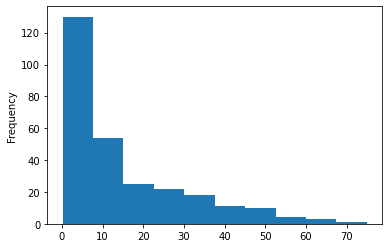

In [76]:
cindex_distro.plot.hist(by='cindex')
plt.show()

Visualizing the cindex distribution gives us a much clearer picture: the nonzero values resemble exponential decay! That's very interesting and may give us key insight into how to engineer feature cutoff points (probably it will be on an exponential scale), and possible transformations to apply to the feature (e.g. often people take the log, etc.)

-an example idea that is quasi-exponential: how many moves above 0, how many moves above 3, how many moves above 9, how many moves above 22, how many moves above 49, etc.  And some of these features will prove more or less useful, so some may be discarded in our final model, which has the great effect of making our dataset less wide

array([[-3.72933884e+01,  3.70512087e-15],
       [-2.94131506e+01,  1.75700862e-10],
       [-2.15329129e+01,  7.21745846e-07],
       [-1.36526751e+01,  2.63296281e-04],
       [-5.77243729e+00,  9.08984084e-03],
       [ 2.10780049e+00,  3.64334729e-02],
       [ 9.98803828e+00,  3.22168150e-02],
       [ 1.78682761e+01,  1.65287665e-02],
       [ 2.57485138e+01,  1.05232713e-02],
       [ 3.36287516e+01,  7.86053216e-03],
       [ 4.15089894e+01,  5.59970118e-03],
       [ 4.93892272e+01,  4.49786331e-03],
       [ 5.72694650e+01,  2.24058493e-03],
       [ 6.51497028e+01,  1.05134414e-03],
       [ 7.30299406e+01,  4.54606590e-04],
       [ 8.09101783e+01,  1.48271804e-04],
       [ 8.87904161e+01,  6.41406095e-06],
       [ 9.66706539e+01,  2.39228061e-08],
       [ 1.04550892e+02,  7.45890472e-12],
       [ 1.12431129e+02,  1.94007276e-16]])

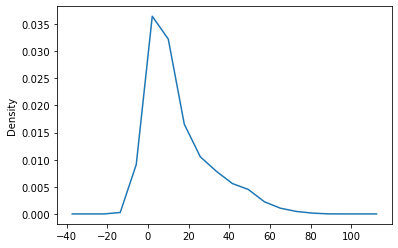

In [89]:
cindex_distro.plot.density(ind=20).get_lines()[0].get_xydata()

What do the value below 0 mean here? This actually seems a bit overcomplicated and difficult to interpret for our data, so it probably isn't that helpful.  **The exponential insight from the histogram is more straightforward and useful.**

Now let's do the same thing for the move powers as we did for their cindex:

In [90]:
power_distro = moves_cindex_distro.loc[moves_cindex_distro['power'] > 0, 'power']
power_distro

Acid              40.0
Aurora Beam       65.0
Bind              15.0
Bite              60.0
Blizzard         110.0
                 ...  
Skitter Smack     70.0
Steel Beam       140.0
Steel Roller     130.0
Terrain Pulse     50.0
Triple Axel       20.0
Name: power, Length: 318, dtype: float64

In [91]:
power_distro.describe(percentiles = [n/20 for n in range(1, 20)])

count    318.000000
mean      74.789308
std       33.896990
min       15.000000
5%        25.000000
10%       40.000000
15%       40.000000
20%       42.000000
25%       50.000000
30%       60.000000
35%       60.000000
40%       65.000000
45%       70.000000
50%       70.000000
55%       75.000000
60%       80.000000
65%       80.000000
70%       85.000000
75%       90.000000
80%      100.000000
85%      110.000000
90%      120.000000
95%      140.000000
max      250.000000
Name: power, dtype: float64

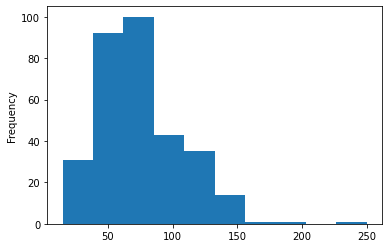

In [92]:
power_distro.plot.hist(by='power')
plt.show()

This is a very different distribution from the cindex, not exponential.  It's closer to normal, but significantly right tailed.  So perhaps our cutoffs would be slightly more concentrated on the left side, but no need for them to be close to exponentially distributed.

array([[-1.02500000e+02,  4.21131979e-30],
       [-5.97727273e+01,  1.62189769e-14],
       [-1.70454545e+01,  9.68382269e-06],
       [ 2.56818182e+01,  4.85277281e-03],
       [ 6.84090909e+01,  1.27113413e-02],
       [ 1.11136364e+02,  4.35387662e-03],
       [ 1.53863636e+02,  1.48819275e-03],
       [ 1.96590909e+02,  1.11809198e-04],
       [ 2.39318182e+02,  7.13723782e-05],
       [ 2.82045455e+02,  1.32964247e-06],
       [ 3.24772727e+02,  3.01278996e-15],
       [ 3.67500000e+02,  8.28686029e-31]])

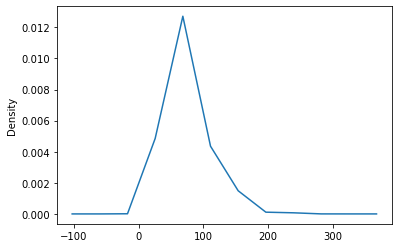

In [103]:
power_distro.plot.density(ind=12).get_lines()[0].get_xydata()

Yet again, this is complicated and difficult to interpret, with some very extreme and unusable values, and even the values within the proper range aren't as straightforward as the percentiles we learned from the describe method.

Some a more useful set of feature cutoff points for power might be something like: moves above 0 power, moves above 50  power, moves above 70 power, moves above 90 power, moves above 140 power (this will hit key percentiles and is somewhat more concentrated around the left, maybe we could change 90 to 85 and forget the 140 or change it to 110 to make it even more that way, etc.)

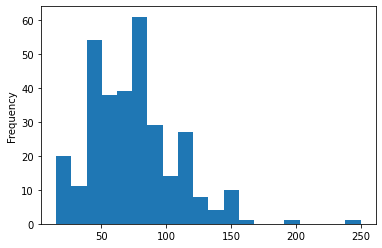

In [104]:
power_distro.plot.hist(by='power', bins=20)
plt.show()

In [105]:
pd.cut(power_distro, 20).value_counts().sort_index()

(14.765, 26.75]    20
(26.75, 38.5]      11
(38.5, 50.25]      54
(50.25, 62.0]      38
(62.0, 73.75]      39
(73.75, 85.5]      61
(85.5, 97.25]      29
(97.25, 109.0]     14
(109.0, 120.75]    27
(120.75, 132.5]     8
(132.5, 144.25]     4
(144.25, 156.0]    10
(156.0, 167.75]     1
(167.75, 179.5]     0
(179.5, 191.25]     0
(191.25, 203.0]     1
(203.0, 214.75]     0
(214.75, 226.5]     0
(226.5, 238.25]     0
(238.25, 250.0]     1
Name: power, dtype: int64

Or, going by the visual graph (which we are expanding here), some decent cutoffs seem to be:
- 15 or 14.765
- 40 or 38.5
- 75 or 73.75
- 110 or 109.0
- 145 or 144.25

These capture the largest jumps, though I may try some different bin sizes later (10, 20 like this, 30 and 40) to check the consistency of these values

**This worked very well!!!** Now we will move to ability_cindex in much the same way, and after that, roles_dict and domain knowledge about the roles, and finally I will actually narrow down and build the features I plan on using (though a final narrowing down will take place during pre-processing as well, for now we are mostly exploring so the narrowing down is only partial).

<a class="anchor" id="current-loc"><font size=6>Current Location<font></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
from bs4 import BeautifulSoup

pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

with open("smogonpokemondata2021/smogonpokemondata2021/scraped_data/PokemonData2021.csv", encoding="utf8") as infile:
    strategydex_df = pd.read_csv(infile)

strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<p>.+?<\/p>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<section>.+?<\/section>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<h1>.+?<\/h1>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\\\\n', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace("\'", '\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('King\"s', "King\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Maki\"s', "Maki\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Land\"s', "Land\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Dragon\"s', "Dragon\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Sirfetch\"d', "Sirfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Farfetch\"d', "Farfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Nature\"s', "Nature\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Forest\"s', "Forest\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('drampa\"s', "drampa\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('False', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('True', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('None', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\"\"\"\s', '\"', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<ul>.+?<\/ul', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Swipe', 'False Swipe') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Surrender', 'False Surrender') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].apply(json.loads)

acceptable_formats = pokemon_df['formats'].unique().tolist()
acceptable_formats.append('ZU')

strategies_dict = {}
strategydexcopy = strategydex_df.copy()

for pokemon in pokemon_df.index:
    pokemon_access = pokemon.replace("'", "").replace(" ", "-").replace(".", "").replace("-10%", "").replace(":", "")
    dex_entry = strategydexcopy.loc[strategydexcopy['pokemonName'] == pokemon_access.lower(), 'pokemonData'].item()
    format_list = []
    for competitive_format in dex_entry['strategies']:
        format_dict = {}
        current_format = competitive_format['format']
        if current_format in acceptable_formats:
            moveset_list = []
            for moveset in competitive_format['movesets']:
                moveset_dict = {}
                moveset_name = moveset['name']
                move_list = []
                for move in moveset['moveslots']:
                    for entry in move:
                        move_list.append(entry['move'])
                moveset_dict[moveset_name] = move_list
                moveset_dict["abilities"] = moveset['abilities']
                moveset_list.append(moveset_dict)
            format_dict[current_format] = moveset_list
            format_list.append(format_dict)
    strategies_dict[pokemon] = format_list

pokemon_df.loc[pokemon_df['formats'] == 'LC', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'NFE', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'Untiered', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'PUBL', 'formats'] = 'NU'
pokemon_df.loc[pokemon_df['formats'] == 'NUBL', 'formats'] = 'RU'
pokemon_df.loc[pokemon_df['formats'] == 'RUBL', 'formats'] = 'UU'
pokemon_df.loc[pokemon_df['formats'] == 'UUBL', 'formats'] = 'OU'

ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']

for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if best_tier == 'OU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
    elif best_tier == 'UU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
        elif 'OU' in possible_tiers:
            best_tier = 'OU'
    elif best_tier == 'RU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
    elif best_tier == 'NU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
        elif 'RU' in possible_tiers:
            best_tier = 'RU'
    elif best_tier == 'PU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
    elif best_tier == 'ZU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
        elif 'PU' in possible_tiers:
            best_tier = 'PU'
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df.loc['Tentacruel', 'Change'] = 'UU'
tierchange_df.loc['Zygarde-10%', 'Change'] = 'UU'
tierchange_df.loc['Tapu Bulu', 'Change'] = 'OU'
tierchange_df.loc['Slurpuff', 'Change'] = 'RU'
tierchange_df.loc['Inteleon', 'Change'] = 'NU'
tierchange_df.loc['Mudsdale', 'Change'] = 'NU'
tierchange_df.loc['Drapion', 'Change'] = 'NU'
tierchange_df.loc['Zoroark', 'Change'] = 'NU'
tierchange_df.loc['Glastrier', 'Change'] = 'NU'
tierchange_df.loc['Omastar', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Ground', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Fairy', 'Change'] = 'PU'
tierchange_df.loc['Hitmonlee', 'Change'] = 'PU'
tierchange_df.loc['Charizard', 'Change'] = 'PU'
tierchange_df.loc['Sneasel', 'Change'] = 'PU'
tierchange_df.loc['Rotom', 'Change'] = 'PU'
tierchange_df.loc['Stunfisk-Galar', 'Change'] = 'PU'
tierchange_df.loc['Centiskorch', 'Change'] = 'PU'

pokemon_df['formats'] = tierchange_df['Change']

r = requests.get('https://bulbapedia.bulbagarden.net/wiki/Type')
html_doc = r.text
soup = BeautifulSoup(html_doc)

type_table = soup.find_all('table')[1]
type_rows = type_table.find_all('tr')
type_list = []

for th in type_rows[1].find_all('th'):
    type_prep = th.a.get('href')
    type_list.append(type_prep.replace('/wiki/', '').replace('_(type)', ''))

type_matchups = pd.DataFrame(index=type_list, columns=type_list)

for i1, tr in enumerate(type_rows[2:20]):
    for i2, td in enumerate(tr.find_all('td')):
        type_matchups.iloc[i1, i2] = float(td.contents[0][0].replace('½', '0.5'))
        
type_matchups.index.rename('Attacking', inplace=True)
type_matchups.columns.rename('Defending', inplace=True)
pokemon_types_matchups = pd.DataFrame(1, index=pokemon_types_df.index, columns=type_matchups.columns.rename(''))

for column in pokemon_types_df.columns:
    type_matchup = type_matchups[column]
    type_filter = pokemon_types_df[column] == 1
    pokemon_types_matchups[type_filter] = pokemon_types_matchups[type_filter] * type_matchup
    
pokemon_types_summary = pd.DataFrame(index=pokemon_types_matchups.index, columns=['2', '4', '0.5', '0.25', '0'])
for column in pokemon_types_summary.columns:
    pokemon_types_summary[column] = (pokemon_types_matchups == float(column)).sum(axis=1)
    
pokemon_types_summary.columns = ['Weaknesses', 'Strong Weaknesses', 'Resists', 'Strong Resists', 'Immune']
pokemon_types_summary['STAB'] = pokemon_types_df.sum(axis=1)
pokemon_types_summary['Resistance Index'] = pokemon_types_summary['Resists'] + 2*pokemon_types_summary['Strong Resists'] + 4*pokemon_types_summary['Immune'] - pokemon_types_summary['Weaknesses'] - 2*pokemon_types_summary['Strong Weaknesses']

roles_dict = {}
for pokemon, formatlist in strategies_dict.items():
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                role_dict = {}
                role_dict['name'] = pokemon
                role_dict['format'] = formatkey
                role_dict['abilities'] = moveset['abilities']
                role = [name for name in moveset.keys() if name != 'abilities'][0]
                role_dict['moveset'] = moveset[role]
                if role not in roles_dict.keys():
                    roles_dict[role] = [role_dict]
                else:
                    roles_dict[role].append(role_dict)
                    
roles_list = sorted(list(roles_dict.keys()))

pokemon_learnsets_df['Acid Armor'] = pokemon_learnsets_df['Acid Armor'] + pokemon_learnsets_df['Iron Defense']
pokemon_learnsets_df.drop('Iron Defense', inplace=True, axis=1)
pokemon_learnsets_df['Agility'] = pokemon_learnsets_df['Agility'] + pokemon_learnsets_df['Rock Polish']
pokemon_learnsets_df.drop('Rock Polish', inplace=True, axis=1)
pokemon_learnsets_df['Charm'] = pokemon_learnsets_df['Charm'] + pokemon_learnsets_df['Feather Dance']
pokemon_learnsets_df.drop('Feather Dance', inplace=True, axis=1)
pokemon_learnsets_df['Smokescreen'] = pokemon_learnsets_df['Smokescreen'] + pokemon_learnsets_df['Sand Attack']
pokemon_learnsets_df.drop('Sand Attack', inplace=True, axis=1)
pokemon_learnsets_df['Heal Pulse'] = pokemon_learnsets_df['Heal Pulse'] + pokemon_learnsets_df['Floral Healing']
pokemon_learnsets_df.drop('Floral Healing', inplace=True, axis=1)
pokemon_learnsets_df['Leer'] = pokemon_learnsets_df['Leer'] + pokemon_learnsets_df['Tail Whip']
pokemon_learnsets_df.drop('Tail Whip', inplace=True, axis=1)
pokemon_learnsets_df['Lock-On'] = pokemon_learnsets_df['Lock-On'] + pokemon_learnsets_df['Mind Reader']
pokemon_learnsets_df.drop('Mind Reader', inplace=True, axis=1)
pokemon_learnsets_df['Block'] = pokemon_learnsets_df['Block'] + pokemon_learnsets_df['Mean Look']
pokemon_learnsets_df.drop('Mean Look', inplace=True, axis=1)
pokemon_learnsets_df['Lunar Dance'] = pokemon_learnsets_df['Lunar Dance'] + pokemon_learnsets_df['Healing Wish']
pokemon_learnsets_df.drop('Healing Wish', inplace=True, axis=1)
pokemon_learnsets_df['Moonlight'] = pokemon_learnsets_df['Moonlight'] + pokemon_learnsets_df['Morning Sun'] + pokemon_learnsets_df['Synthesis']
pokemon_learnsets_df.drop(['Morning Sun', 'Synthesis'], inplace=True, axis=1)
pokemon_learnsets_df['Recover'] = pokemon_learnsets_df['Recover'] + pokemon_learnsets_df['Soft-Boiled'] + pokemon_learnsets_df['Milk Drink'] + pokemon_learnsets_df['Slack Off']
pokemon_learnsets_df.drop(['Soft-Boiled', 'Milk Drink', 'Slack Off'], inplace=True, axis=1)
pokemon_learnsets_df['Trick'] = pokemon_learnsets_df['Trick'] + pokemon_learnsets_df['Switcheroo']
pokemon_learnsets_df.drop('Switcheroo', inplace=True, axis=1)

pokemon_learnsets_df.where(pokemon_learnsets_df <= 1, 1, inplace=True)

cindex_dict = strategies_dict.copy()
pokemon_noncompetitive = []

for key, value in strategies_dict.items():
    if value == []:
        pokemon_noncompetitive.append(key)
        cindex_dict.pop(key)
        
dup_moves = ['Acid Armor', 'Iron Defense', 'Rock Polish', 'Agility', 'Charm', 'Feather Dance', 'Smokescreen', 'Sand Attack', 'Heal Pulse', 'Floral Healing', 'Leer', 'Tail Whip', 'Lock-On', 'Mind Reader', 'Mean Look', 'Block', 'Healing Wish', 'Lunar Dance', 'Moonlight', 'Morning Sun', 'Synthesis', 'Recover', 'Soft-Boiled', 'Milk Drink', 'Slack Off', 'Trick', 'Switcheroo']

dup_moves_df = pd.DataFrame(index=dup_moves, columns=['collapse'])
dup_moves_df.loc[['Acid Armor', 'Iron Defense'], 'collapse'] = 'Acid Armor'
dup_moves_df.loc[['Rock Polish', 'Agility'], 'collapse'] = 'Agility'
dup_moves_df.loc[['Charm', 'Feather Dance'], 'collapse'] = 'Charm'
dup_moves_df.loc[['Smokescreen', 'Sand Attack'], 'collapse'] = 'Smokescreen'
dup_moves_df.loc[['Heal Pulse', 'Floral Healing'], 'collapse'] = 'Heal Pulse'
dup_moves_df.loc[['Leer', 'Tail Whip'], 'collapse'] = 'Leer'
dup_moves_df.loc[['Lock-On', 'Mind Reader'], 'collapse'] = 'Lock-On'
dup_moves_df.loc[['Mean Look', 'Block'], 'collapse'] = 'Block'
dup_moves_df.loc[['Healing Wish', 'Lunar Dance'], 'collapse'] = 'Lunar Dance'
dup_moves_df.loc[['Moonlight', 'Morning Sun', 'Synthesis'], 'collapse'] = 'Moonlight'
dup_moves_df.loc[['Recover', 'Soft-Boiled', 'Milk Drink', 'Slack Off'], 'collapse'] = 'Recover'
dup_moves_df.loc[['Trick', 'Switcheroo'], 'collapse'] = 'Trick'

moves_cindex = pd.DataFrame(0, index=pokemon_learnsets_df.columns, columns=['n_learnset', 'n_competitive', 'cindex'])

for pokemon, formatlist in cindex_dict.items():
    already_checked = []
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                moveset_name = [name for name in moveset.keys() if name != 'abilities'][0]
                for move in moveset[moveset_name]:
                    if move in dup_moves:
                        move = dup_moves_df.loc[move, 'collapse']
                    if move not in already_checked:
                        moves_cindex.loc[move, 'n_competitive'] += 1
                        already_checked.append(move)

for move in pokemon_learnsets_df.drop(index=pokemon_noncompetitive).columns:
    moves_cindex.loc[move, 'n_learnset'] = pokemon_learnsets_df[move].sum()

for move in moves_cindex.index:
    moves_cindex.loc[move, 'power'] = moves_df.loc[move, 'power']
    moves_cindex.loc[move, 'type'] = moves_df.loc[move, 'type']
    moves_cindex.loc[move, 'category'] = moves_df.loc[move, 'category']
    
moves_cindex['cindex'] = 100*(moves_cindex['n_competitive'] / moves_cindex['n_learnset'])

n_learnset = moves_cindex['n_learnset'].value_counts()
moves_cindex_distro = moves_cindex[moves_cindex['n_learnset'] > 2]
cindex_distro = moves_cindex_distro.loc[moves_cindex_distro['cindex'] > 0, 'cindex']
power_distro = moves_cindex_distro.loc[moves_cindex_distro['power'] > 0, 'power']

In [2]:
pokemon_abilities_df

,Cute Charm,Effect Spore,Flame Body,Flash Fire,Intimidate,Lightning Rod,Minus,Plus,Poison Point,Pressure,...,Quick Draw,Ripen,Sand Spit,Screen Cleaner,Stalwart,Steam Engine,Steely Spirit,Transistor,Unseen Fist,Wandering Spirit
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmander,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the same as we changed pokemon_learnsets_df for moves_cindex, we need to change pokemon_abilities_df for abilities_cindex, collapsing together moves that are literally identical in all but name so that the model doesn't make the mistake of treating them differently:

Identical Ability List:
- Air Lock, Cloud Nine
- Battle Armor, Shell Armor
- Clear Body, White Smoke, Full Metal Body
- Filter, Solid Rock, Prism Armor
- Gooey, Tangling Hair
- Insomnia, Vital Spirit
- Mold Breaker, Teravolt, Turboblaze
- Moxie, Chilling Neigh
- Multiscale, Shadow Shield
- Propeller Tail, Stalwart
- Rough Skin, Iron Barbs
- Wimp Out, Emergency Exit

Researcher from: https://bulbapedia.bulbagarden.net/wiki/Ability_variations

As before, I will use the ability with the shortest name in each group

In [3]:
pokemon_abilities_df['Air Lock'] = pokemon_abilities_df['Air Lock'] + pokemon_abilities_df['Cloud Nine']
pokemon_abilities_df.drop('Cloud Nine', inplace=True, axis=1)
pokemon_abilities_df['Shell Armor'] = pokemon_abilities_df['Battle Armor'] + pokemon_abilities_df['Shell Armor']
pokemon_abilities_df.drop('Battle Armor', inplace=True, axis=1)
pokemon_abilities_df['Clear Body'] = pokemon_abilities_df['Clear Body'] + pokemon_abilities_df['White Smoke'] + pokemon_abilities_df['Full Metal Body']
pokemon_abilities_df.drop(['White Smoke', 'Full Metal Body'], inplace=True, axis=1)
pokemon_abilities_df['Filter'] = pokemon_abilities_df['Filter'] + pokemon_abilities_df['Solid Rock'] + pokemon_abilities_df['Prism Armor']
pokemon_abilities_df.drop(['Solid Rock', 'Prism Armor'], inplace=True, axis=1)
pokemon_abilities_df['Gooey'] = pokemon_abilities_df['Gooey'] + pokemon_abilities_df['Tangling Hair']
pokemon_abilities_df.drop('Tangling Hair', inplace=True, axis=1)
pokemon_abilities_df['Insomnia'] = pokemon_abilities_df['Insomnia'] + pokemon_abilities_df['Vital Spirit']
pokemon_abilities_df.drop('Vital Spirit', inplace=True, axis=1)
pokemon_abilities_df['Teravolt'] = pokemon_abilities_df['Mold Breaker'] + pokemon_abilities_df['Teravolt'] + pokemon_abilities_df['Turboblaze']
pokemon_abilities_df.drop(['Mold Breaker', 'Turboblaze'], inplace=True, axis=1)
pokemon_abilities_df['Moxie'] = pokemon_abilities_df['Moxie'] + pokemon_abilities_df['Chilling Neigh']
pokemon_abilities_df.drop('Chilling Neigh', inplace=True, axis=1)
pokemon_abilities_df['Multiscale'] = pokemon_abilities_df['Multiscale'] + pokemon_abilities_df['Shadow Shield']
pokemon_abilities_df.drop('Shadow Shield', inplace=True, axis=1)
pokemon_abilities_df['Stalwart'] = pokemon_abilities_df['Propeller Tail'] + pokemon_abilities_df['Stalwart']
pokemon_abilities_df.drop('Propeller Tail', inplace=True, axis=1)
pokemon_abilities_df['Rough Skin'] = pokemon_abilities_df['Rough Skin'] + pokemon_abilities_df['Iron Barbs']
pokemon_abilities_df.drop('Iron Barbs', inplace=True, axis=1)
pokemon_abilities_df['Wimp Out'] = pokemon_abilities_df['Wimp Out'] + pokemon_abilities_df['Emergency Exit']
pokemon_abilities_df.drop('Emergency Exit', inplace=True, axis=1)

pokemon_abilities_df

,Cute Charm,Effect Spore,Flame Body,Flash Fire,Intimidate,Lightning Rod,Minus,Plus,Poison Point,Pressure,...,Quick Draw,Ripen,Sand Spit,Screen Cleaner,Stalwart,Steam Engine,Steely Spirit,Transistor,Unseen Fist,Wandering Spirit
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmander,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


15 fewer abilities is exactly correct since we dealt with 27 and kept 12 of them

In [4]:
pokemon_abilities_df[pokemon_abilities_df > 1].sum().sum()

2.0

In [5]:
overcounted_abilities = pokemon_abilities_df[pokemon_abilities_df > 1].sum()
overcounted_abilities.value_counts()

0.0    226
2.0      1
dtype: int64

In [6]:
overcounted_abilities[overcounted_abilities > 1].index

Index(['Insomnia'], dtype='object')

Some research indicates that it's Delibird which has both Insomnia and Vital Spirit, even though those abilities have the same effect.  So we need to just bring that back to 1 one-hot encoded for this features instead of scoring him as 2 (since there is no value in having both of them compared to having 1, as they do the exact same thing).

https://www.smogon.com/dex/ss/pokemon/delibird/

In [7]:
pokemon_abilities_df.where(pokemon_abilities_df <= 1, 1, inplace=True)
pokemon_abilities_df

,Cute Charm,Effect Spore,Flame Body,Flash Fire,Intimidate,Lightning Rod,Minus,Plus,Poison Point,Pressure,...,Quick Draw,Ripen,Sand Spit,Screen Cleaner,Stalwart,Steam Engine,Steely Spirit,Transistor,Unseen Fist,Wandering Spirit
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmander,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmeleon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calyrex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
pokemon_abilities_df[pokemon_abilities_df > 1].sum().sum()

0.0

In [9]:
overcounted_abilities = pokemon_abilities_df[pokemon_abilities_df > 1].sum()
overcounted_abilities.value_counts()

0.0    227
dtype: int64

We don't need to re-create the cindex dict, since we can use the same one as was used by moves_cindex_df.  But, we do need a dataframe of duplicate abilities, just as we did of duplicate moves:

In [10]:
dup_abilities= ['Air Lock', 'Cloud Nine', 'Battle Armor', 'Shell Armor', 'Clear Body', 'White Smoke', 'Full Metal Body', 'Filter', 'Solid Rock', 'Prism Armor', 'Gooey', 'Tangling Hair', 'Insomnia', 'Vital Spirit', 'Mold Breaker', 'Teravolt', 'Turboblaze', 'Moxie', 'Chilling Neigh', 'Multiscale', 'Shadow Shield', 'Propeller Tail', 'Stalwart', 'Rough Skin', 'Iron Barbs', 'Wimp Out', 'Emergency Exit']

dup_abilities_df = pd.DataFrame(index=dup_abilities, columns=['collapse'])
dup_abilities_df.loc[['Air Lock', 'Cloud Nine'], 'collapse'] = 'Air Lock'
dup_abilities_df.loc[['Battle Armor', 'Shell Armor'], 'collapse'] = 'Shell Armor'
dup_abilities_df.loc[['Clear Body', 'White Smoke', 'Full Metal Body'], 'collapse'] = 'Clear Body'
dup_abilities_df.loc[['Filter', 'Solid Rock', 'Prism Armor'], 'collapse'] = 'Filter'
dup_abilities_df.loc[['Gooey', 'Tangling Hair'], 'collapse'] = 'Gooey'
dup_abilities_df.loc[['Insomnia', 'Vital Spirit'], 'collapse'] = 'Insomnia'
dup_abilities_df.loc[['Mold Breaker', 'Teravolt', 'Turboblaze'], 'collapse'] = 'Teravolt'
dup_abilities_df.loc[['Moxie', 'Chilling Neigh'], 'collapse'] = 'Moxie'
dup_abilities_df.loc[['Multiscale', 'Shadow Shield'], 'collapse'] = 'Multiscale'
dup_abilities_df.loc[['Propeller Tail', 'Stalwart'], 'collapse'] = 'Stalwart'
dup_abilities_df.loc[['Rough Skin', 'Iron Barbs'], 'collapse'] = 'Rough Skin'
dup_abilities_df.loc[['Wimp Out', 'Emergency Exit'], 'collapse'] = 'Wimp Out'

dup_abilities_df

,collapse
Air Lock,Air Lock
Cloud Nine,Air Lock
Battle Armor,Shell Armor
Shell Armor,Shell Armor
Clear Body,Clear Body
White Smoke,Clear Body
Full Metal Body,Clear Body
Filter,Filter
Solid Rock,Filter
Prism Armor,Filter


Now, we will create abilities_cindex in almost the same way we did moves_cindex, but we should look at abilities_df first and see if there are any interesting features of abilities we'd also like to examine (as we did for move 'power')

In [12]:
abilities_df

,description
name,
Cute Charm,30% chance of infatuating Pokemon of the oppos...
Effect Spore,30% chance of poison/paralysis/sleep on others...
Flame Body,30% chance a Pokemon making contact with this ...
Flash Fire,This Pokemon's Fire attacks do 1.5x damage if ...
Intimidate,"On switch-in, this Pokemon lowers the Attack o..."
...,...
Steam Engine,This Pokemon's Speed is raised by 6 stages aft...
Steely Spirit,This Pokemon and its allies' Steel-type moves ...
Transistor,This Pokemon's attacking stat is multiplied by...


As it turns out there AREN'T any interesting features of abilities except descriptions, so we'll just go right into creating abilities_cindex

In [13]:
abilities_cindex = pd.DataFrame(0, index=pokemon_abilities_df.columns, columns=['n_abilityset', 'n_competitive', 'cindex'])

for pokemon, formatlist in cindex_dict.items():
    already_checked = []
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                for ability in moveset['abilities']:
                    if ability in dup_abilities:
                        ability = dup_abilities_df.loc[ability, 'collapse']
                    if ability not in already_checked:
                        abilities_cindex.loc[ability, 'n_competitive'] += 1
                        already_checked.append(ability)
                        
for ability in pokemon_abilities_df.drop(index=pokemon_noncompetitive).columns:
    abilities_cindex.loc[ability, 'n_abilityset'] = pokemon_abilities_df[ability].sum()
    
abilities_cindex

,n_abilityset,n_competitive,cindex
Cute Charm,12,1,0
Effect Spore,7,2,0
Flame Body,18,6,0
Flash Fire,17,7,0
Intimidate,22,8,0
...,...,...,...
Steam Engine,3,0,0
Steely Spirit,1,1,0
Transistor,1,1,0
Unseen Fist,2,2,0


In [14]:
abilities_cindex['cindex'] = 100*(abilities_cindex['n_competitive'] / abilities_cindex['n_abilityset'])
abilities_cindex

,n_abilityset,n_competitive,cindex
Cute Charm,12,1,8.333333
Effect Spore,7,2,28.571429
Flame Body,18,6,33.333333
Flash Fire,17,7,41.176471
Intimidate,22,8,36.363636
...,...,...,...
Steam Engine,3,0,0.000000
Steely Spirit,1,1,100.000000
Transistor,1,1,100.000000
Unseen Fist,2,2,100.000000


In [15]:
abilities_cindex['cindex'].describe(percentiles = [n/20 for n in range(1, 20)])

count    227.000000
mean      36.688162
std       36.690654
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%        0.000000
35%        9.234450
40%       17.647059
45%       24.166667
50%       33.333333
55%       33.333333
60%       42.857143
65%       50.000000
70%       50.000000
75%       55.183946
80%       62.222222
85%      100.000000
90%      100.000000
95%      100.000000
max      200.000000
Name: cindex, dtype: float64

Compared to moves_cindex, the results are slightly different.
- There is an even higher percentage of 100 cindex abilities, which makes sense since abilities are generally available to far fewer pokemon than most moves.  These 100 cindex abilities will likely be turned into a feature similar to how this was done with moves_cindex, but we should examine them more closely to understand how we should do that.
- There is an even LOWER percentage of 0 cindex abilities, which makes sense since pokemon only have access to 1 to 4 abilities, so they have fewer chances not to use the abilities they have compared to their own massive movesets.
- There is at least one 200 valued ability, which I'm concerned is an error.

Let's take a closer look at the 200, 100 and 0 values.

In [16]:
abilities_cindex[abilities_cindex['cindex'] > 100]

,n_abilityset,n_competitive,cindex
Power Construct,1,2,200.0


I have a guess as to what happened: I manually removed Power construct from the ability set of Zygarde-10% (if I hadn't, n_ability would be 2 for this ability so there would be no error), because Zygarde-10% is generally used in UU tier where this ability is banned, whereas regular Zygarde can use it in Ubers.  But, I didn't remove it from the competitive movesets of Zygarde-10% in roles_dict, so it was picked up twice in n_competitive.  We need to check two things:

- Since we messed with the tiers, we should make sure Zygarde-10% is still in UU, or whether he moved up to Ubers.
- If he moved up to Ubers, I should restore his ability Power Construct in pokemon_abilities_df, and manually raise n_ability to 2 for this move.  If he did not move up to Ubers, I will just manually lower n_competitive to 1 for this move and leave it at that.

In [18]:
pokemon_df.loc['Zygarde-10%', :]

hp              54
atk            100
def             71
spa             61
spd             85
spe            115
weight        33.5
height         1.2
formats         UU
generation      SM
Name: Zygarde-10%, dtype: object

In [19]:
tierchange_df.loc['Zygarde-10%', :]

Tier      UU
Change    UU
Name: Zygarde-10%, dtype: object

It looks like I manually moved Zygarde-10% back down to UU, even though he has an Uber moveset, since according to the Smogon Uber viability rankings compiled by experts, Zygarde-10% is not really viable in Ubers (since Base Zygarde is so much stronger).  Therefore, I will just move n_competitive back down to 1 manually for this move, since this was just a mistake due to a not really used moveset that Zygarde-10% has listed in his roles_dict entry.

Then we'll start over and re-calculate the cindex.

In [20]:
abilities_cindex.loc['Power Construct', 'n_competitive'] = 1

abilities_cindex['cindex'] = 100*(abilities_cindex['n_competitive'] / abilities_cindex['n_abilityset'])

abilities_cindex['cindex'].describe(percentiles = [n/20 for n in range(1, 20)])

count    227.000000
mean      36.247634
std       35.294945
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%        0.000000
35%        9.234450
40%       17.647059
45%       24.166667
50%       33.333333
55%       33.333333
60%       42.857143
65%       50.000000
70%       50.000000
75%       55.183946
80%       62.222222
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

With that error solved, let's examine the 100 cindex abilities:

In [21]:
abilities_cindex.loc[abilities_cindex['cindex'] == 100]

,n_abilityset,n_competitive,cindex
Wonder Guard,1,1,100.0
Drizzle,3,3,100.0
Imposter,1,1,100.0
Multiscale,3,3,100.0
Victory Star,1,1,100.0
Pixilate,1,1,100.0
Stance Change,1,1,100.0
Dark Aura,1,1,100.0
Fairy Aura,1,1,100.0
Fur Coat,1,1,100.0


So this is pretty similar to the 100 cindex moves, the only difference being that they occur with abilities that have n_abilityset of 1, 2 and 3 rather than just 1 and 2 as for moves (which may mean our unique powerful ability feature will require (n_abilityset <= 3) rather than 2.  Though we do need to do some statistical tests before making that final decision.

But let's look at the 0 abilities:

In [22]:
abilities_cindex.loc[abilities_cindex['cindex'] == 0]

,n_abilityset,n_competitive,cindex
Minus,5,0,0.0
Plus,5,0,0.0
Poison Point,16,0,0.0
Rain Dish,12,0,0.0
Shadow Tag,5,0,0.0
...,...,...,...
Quick Draw,1,0,0.0
Ripen,3,0,0.0
Sand Spit,2,0,0.0
Stalwart,3,0,0.0


In [23]:
abilities_cindex.loc[abilities_cindex['cindex'] == 0].describe(percentiles = [n/20 for n in range(1, 20)])

,n_abilityset,n_competitive,cindex
count,70.000000,70.0,70.0
mean,6.185714,0.0,0.0
std,5.971655,0.0,0.0
min,1.000000,0.0,0.0
5%,1.000000,0.0,0.0
10%,1.000000,0.0,0.0
15%,1.000000,0.0,0.0
20%,1.000000,0.0,0.0
25%,1.000000,0.0,0.0
30%,2.000000,0.0,0.0


There doesn't seem to be much of interests in the 0 cindex abilities (which will be removed from the distribution, since they won't be counted in the aggregated features anyways)

We will do something like n_learnset for abilities next, called n_abilityset:

In [24]:
n_abilityset = abilities_cindex['n_abilityset'].value_counts()
n_abilityset

1     47
2     29
5     18
3     15
4     13
9     11
6     10
10     9
7      7
17     7
12     7
8      6
13     6
14     6
15     5
11     4
20     4
22     4
16     3
23     3
18     2
19     2
21     2
28     2
24     1
26     1
30     1
32     1
34     1
Name: n_abilityset, dtype: int64

From eyeballing it, it would seem again that only 1 and 2 have the chance to be outliers, whereas 3 probably is not, but let's check the statistics:

from scipy import stats
​
n_learnset[np.abs(stats.zscore(n_learnset)) > 3]
1    82
2    26
Name: n_learnset, dtype: int64
n_learnset[np.abs(stats.zscore(n_learnset)) > 2]
1    82
2    26
3    16
Name: n_learnset, dtype: int64
It's fair to say that 1 and 2 are definitely outliers, though we can also examine them more closely. For 3 and 4, there are few enough moves that we could probably examine the specific moves with such values of n_learnset and make a judgment call:

Athough 3 may not be an outlier value, we may need to consider the characteristics of the 100 cindex 3 n_abilityset moves in this case: two are weather setting moves, Drizzle and Psychic Surge, and that will likely be a unique feature on its own.  So we may choose to consider 3 abilities a unique feature for this reason, it depends how we want to double count our weather moves: in ability aggregations, or in another unique features (may in aggregations it would be better, not sure though since then it splits how the weather moves are accounted for

In [25]:
abilities_cindex.loc['Grassy Surge', :]

n_abilityset      4.0
n_competitive     3.0
cindex           75.0
Name: Grassy Surge, dtype: float64

In [29]:
strategies_dict['Grookey']

[{'LC': [{'Offensive': ['Grassy Glide',
     'Wood Hammer',
     'Drain Punch',
     'Knock Off',
     'Swords Dance',
     'Protect',
     'U-turn'],
    'abilities': ['Grassy Surge']}]}]

In [30]:
'Grookey' in pokemon_noncompetitive

False

In [31]:
ranked_formats

['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

In [33]:
cindex_dict['Grookey']

[{'LC': [{'Offensive': ['Grassy Glide',
     'Wood Hammer',
     'Drain Punch',
     'Knock Off',
     'Swords Dance',
     'Protect',
     'U-turn'],
    'abilities': ['Grassy Surge']}]}]

I think I may have found a slight issue that will require me to recalculate the moves_cindex and abilities_cindex (though this will not be too difficult), and also perhaps cindex_dict which may be the root of the problem.

When calculating the n_abilityset and n_learnset columns, I remove pokemon that do not have competitive movesets in cindex_dict.  However, some of the competitive movesets that pokemon have are not in ranked formats (such as Grookey, who has the Grassy Surge ability), and though this Grassy Surge will be excluded from n_competitive since it checks the format, n_abilityset and n_learnset don't check the format, since they are built from pokemon_noncompetitive, which was built during the creation of cindex_dict that didn't discriminate based on the ranked_format of movesets, but only considered whether a pokemon had any movesets at all.

This is a subtle but systematic error which requires me to fix cindex_dict, and redo my analysis of moves_cindex and abilities_cindex which currently have some inflated n_learnset and n_abilityset values.  But I think it will be fixed after this and my analysis should be smoother and more reliable.

I noticed this flaw because my 100 cindex abilities contained almost all the terrain creation abilities (with 'Surge' in them) except Grassy Surge, which I can now see is only not included due to a mistake (the fact that Grookey's Grassy Surge ability only has 3 in n_competitive and 4 in n_abilityset, since it was counted in abilityset due to having a competitive moveset, but that moveset not being in ranked_formats since it's just Little Cup denoted as 'LC', so it wasn't counted in n_competitive